In [1]:
### Installing the required packages if not already installed
packages = ['numpy', 'pandas', 'warnings', 'sqlite3', 'scipy', 'matplotlib', 'numba']

for package in packages:
    try:
        __import__(package)
    except ImportError:
        %pip install {package}

import numpy as np    # For numerical computing
import pandas as pd   # For data manipulation
import sqlite3        # For connecting to SQL database
import statsmodels.api as sm
from scipy.optimize import minimize
import os

### Ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

### Pandas display options
pd.options.display.float_format = '{:.4f}'.format

### Getting some fuctions from the other notebook
%run 99_functions.ipynb

### Setting working directory
os.chdir('/Users/emilwilliamhansen/Desktop/Master-Thesis/Code')

### Extracting the data from the database
conn = sqlite3.connect('Data/data.db')

factor_ret_m = pd.read_sql('SELECT * FROM factors_monthly', conn).set_index('Date').drop(columns='rf')
volatility = pd.read_sql('SELECT * FROM volatility', conn).set_index('Date')
factor_ret_d = pd.read_sql('SELECT * FROM factors_daily', conn).set_index('Date').drop(columns='rf')


conn.close()

### Making sure all the data is in the same format
factor_ret_m.index = pd.to_datetime(factor_ret_m.index)
volatility.index = pd.to_datetime(volatility.index)
factor_ret_d.index = pd.to_datetime(factor_ret_d.index)

### Fixing the index of the factor_ret_m
factor_ret_m = factor_ret_m.loc[volatility.index]

### Since the BAB factor start in 1983, we will only consider the data from 1983 onwards
factor_ret_d = factor_ret_d['1983':]
factor_ret_m = factor_ret_m['1983':]

# Volatility Managed Individual Factor with Shirnkage

In [2]:
### Getting the daily volatilites we are missing using the daily returns
volatility = pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns)
variance = pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns)

for factor in factor_ret_m.columns:
    for date in factor_ret_m.index:
        volatility.loc[date, factor] = factor_ret_d.loc[date.strftime('%Y-%m'), factor].std() * np.sqrt(252)
        variance.loc[date, factor] = factor_ret_d.loc[date.strftime('%Y-%m'), factor].var() * 252

### Calculating the optimal c for each factor
c = pd.DataFrame(columns=factor_ret_m.columns)
c.loc['c_fac', :] = np.nan
c.loc['c_mkt', :] = np.nan

for factor in factor_ret_m.columns:
    def obj_func(c):
        vol_timed = (c / variance[factor]).shift(1) * factor_ret_m[factor]
        return (vol_timed.std() - factor_ret_m.iloc[1:,][factor].std())**2

    res = minimize(obj_func, 0.1)
    c.loc['c_fac', factor] = res.x[0]

for factor in factor_ret_m.columns:
    def obj_func(c):
        vol_timed = (c / variance['MKT']).shift(1) * factor_ret_m[factor]
        return (vol_timed.std() - factor_ret_m.iloc[1:,][factor].std())**2

    res = minimize(obj_func, 0.1)
    c.loc['c_mkt', factor] = res.x[0]

### Getting the volatility timed returns
r_sigma_k, r_sigma_m = pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns), pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns)
r_sigma_k_is, r_sigma_m_is = r_sigma_k.copy(), r_sigma_m.copy()

for factor in factor_ret_m.columns:
    r_sigma_k[factor] = (c.loc['c_fac', factor] / variance[factor]).shift(1) * factor_ret_m[factor]
    r_sigma_m[factor] = (c.loc['c_mkt', factor] / variance['MKT']).shift(1) * factor_ret_m[factor]
    r_sigma_k_is[factor] = (c.loc['c_fac', factor] / volatility[factor]).shift(1) * factor_ret_m[factor]
    r_sigma_m_is[factor] = (c.loc['c_mkt', factor] / volatility['MKT']).shift(1) * factor_ret_m[factor]

### Dropping the first row in all of our returns
r_sigma_k = r_sigma_k.iloc[1:,]
r_sigma_m = r_sigma_m.iloc[1:,]
r_sigma_k_is = r_sigma_k_is.loc[r_sigma_k.index]
r_sigma_m_is = r_sigma_m_is.loc[r_sigma_m.index]
r = factor_ret_m.iloc[1:,]

### Defining the starting window size
window = 120

### Creating a place to store the returns
r_sigma_k_ptf, r_sigma_m_ptf = pd.DataFrame(columns=r.columns, index=r.index).iloc[window:,], pd.DataFrame(columns=r.columns, index=r.index).iloc[window:,]
r_sigma_k_ptf_is, r_sigma_m_ptf_is = pd.DataFrame(columns=r.columns, index=r.index).iloc[window:,], pd.DataFrame(columns=r.columns, index=r.index).iloc[window:,]

### Creating a place to store the out-of-sample weights
r_sigma_k_ptf_w, r_sigma_m_ptf_w = r_sigma_k_ptf.copy(), r_sigma_m_ptf.copy()

### Running the loop
for factor in r.columns:

    ## Starting with creating a dataframe we will use and getting the dates
    data = pd.concat([r[factor], r_sigma_k[factor], r_sigma_m[factor]], axis=1).dropna()
    dates = data.index
    data_is = pd.concat([r[factor], r_sigma_k_is[factor], r_sigma_m_is[factor]], axis=1).dropna()

    for i in range(window, len(data)):
        # Getting the data we need for the expanding window
        data_window = data_is.iloc[:i,]

        # Getting the different weights
        w_k = ptf_weights(data_window.iloc[:,[0,1]], negative=False, type='MVP', gamma = 5, wanted_weight='None', shrinkage=True)
        w_m = ptf_weights(data_window.iloc[:,[0,2]], negative=False, type='MVP', gamma = 5, wanted_weight='None', shrinkage=True)

        # Getting the returns
        r_sigma_k_ptf.loc[dates[i], factor] = (w_k * data.iloc[i,[0,1]].values).sum()
        r_sigma_m_ptf.loc[dates[i], factor] = (w_m * data.iloc[i,[0,2]].values).sum()
    
######## IN-SAMPLE ########

    ## Getting the weights
    w_m = ptf_weights(pd.concat([r[factor], r_sigma_m[factor]], axis=1).iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None', shrinkage=True)
    w_k = ptf_weights(pd.concat([r[factor], r_sigma_k[factor]], axis=1).iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None', shrinkage=True)

    ## Getting the in-sample returns
    r_sigma_m_ptf_is[factor] = (w_m * pd.concat([r[factor], r_sigma_m[factor]], axis=1).iloc[window:,]).sum(axis=1)
    r_sigma_k_ptf_is[factor] = (w_k * pd.concat([r[factor], r_sigma_k[factor]], axis=1).iloc[window:,]).sum(axis=1)

### Making the indexes the same
idx = r_sigma_k_ptf.index
r = r.loc[idx,]
r_sigma_k = r_sigma_k.loc[idx,]
r_sigma_m = r_sigma_m.loc[idx,]

### Getting the p-values
p_values = pd.DataFrame(columns=r.columns, index=['Individual (fac)', 'In-Sample (fac)', 'Out-of-Sample (fac)',
                                                  'Individual (mkt)', 'In-Sample (mkt)', 'Out-of-Sample (mkt)'])

### Number of simulations
n_boot = 100000

### Running the loop
for factor in factor_ret_m.columns:

    ## Getting the data we need for the factor
    data = pd.concat([r[factor], r_sigma_k[factor], r_sigma_k_ptf_is[factor], r_sigma_k_ptf[factor], 
                      r_sigma_m[factor], r_sigma_m_ptf_is[factor], r_sigma_k_ptf[factor]], axis=1)
    
    ## Place to store the differces
    diff = []

    ## Running a loop for the different returns
    for f in range(1, len(data.columns)):

        # Running the loop for the bootstrap
        for i in range(n_boot):
            # Getting the return series
            boot = stationary_bootstrap(np.array(data.iloc[:,[0,f]].astype(float)), 5, len(data))

            #Adding the difference to the list
            diff.append((sharpes_ratio(boot[:,0]) - sharpes_ratio(boot[:,1])))
        
        # Getting the p-value
        p_values[factor][f-1] = (np.sum(np.array(diff) > 0) / (len(diff)))

### Creating a latex table for the thesis
latex = pd.DataFrame(columns=r.columns)

latex.loc[r'\multicolumn{7}{l}{\textit{Panel A: Factor and volatility-managed counterpart using $\sigma_k$}} \\', :] = np.nan
latex.loc[r'SR($r_k$)', :] = sharpes_ratio(r)
latex.loc[r'SR($r_k^{\sigma_k}$)', :] = sharpes_ratio(r_sigma_k)
latex.loc[r'p-value(SR($r_k^{\sigma_k}$) - SR($r_k$))', :] = p_values.loc['Individual (fac)', :]

latex.loc[r'\multicolumn{7}{l}{\textit{Panel B: In-sample volatility-timed individual-factor portfolio using $\sigma_k$}} \\', :] = np.nan
latex.loc[r'SR($r_k$)', :] = sharpes_ratio(r)
latex.loc[r'SR($r_k$, $r_k^{\sigma_k}$)', :] = sharpes_ratio(r_sigma_k_ptf_is)
latex.loc[r'p-value(SR($r_k$, $r_k^{\sigma_k}$) - SR($r_k$))', :] = p_values.loc['In-Sample (fac)', :]

latex.loc[r'\multicolumn{7}{l}{\textit{Panel C: Out-of-sample volatility-timed individual-factor portfolio using $\sigma_k$}} \\', :] = np.nan
latex.loc[r'SR($r_k$)', :] = sharpes_ratio(r)
latex.loc[r'SR($r_k$, $r_k^{\sigma_k}$)', :] = sharpes_ratio(r_sigma_k_ptf)
latex.loc[r'p-value(SR($r_k$, $r_k^{\sigma_k}$) - SR($r_k$))', :] = p_values.loc['Out-of-Sample (fac)', :]

latex.loc[r'\multicolumn{7}{l}{\textit{Panel D: Factor and volatility-managed counterpart using $\sigma_m$}} \\', :] = np.nan
latex.loc[r'SR($r_k$)', :] = sharpes_ratio(r)
latex.loc[r'SR($r_k^{\sigma_m}$)', :] = sharpes_ratio(r_sigma_m)
latex.loc[r'p-value(SR($r_k^{\sigma_m}$) - SR($r_k$))', :] = p_values.loc['Individual (mkt)', :]

latex.loc[r'\multicolumn{7}{l}{\textit{Panel E: In-sample volatility-timed individual-factor portfolio using $\sigma_m$}} \\', :] = np.nan
latex.loc[r'SR($r_k$)', :] = sharpes_ratio(r)
latex.loc[r'SR($r_k$, $r_k^{\sigma_m}$)', :] = sharpes_ratio(r_sigma_m_ptf_is)
latex.loc[r'p-value(SR($r_k$, $r_k^{\sigma_m}$) - SR($r_k$))', :] = p_values.loc['In-Sample (mkt)', :]

latex.loc[r'\multicolumn{7}{l}{\textit{Panel F: Out-of-sample volatility-timed individual-factor portfolio using $\sigma_m$}} \\', :] = np.nan
latex.loc[r'SR($r_k$)', :] = sharpes_ratio(r)
latex.loc[r'SR($r_k$, $r_k^{\sigma_m}$)', :] = sharpes_ratio(r_sigma_m_ptf)
latex.loc[r'p-value(SR($r_k$, $r_k^{\sigma_m}$) - SR($r_k$))', :] = p_values.loc['Out-of-Sample (mkt)', :]

latex.to_latex('Tables/appendix-individual_factors_with_shrinkage.tex', na_rep='', index=True, float_format='%.3f', escape=False, multirow=True, multicolumn=True)
print(latex.to_latex(index=True, float_format='%.3f', escape=False, multirow=True, multicolumn=True))

\begin{tabular}{llllll}
\toprule
 & MKT & SMB & HML & UMD & BAB \\
\midrule
\multicolumn{7}{l}{\textit{Panel A: Factor and volatility-managed counterpart using $\sigma_k$}} \\ & NaN & NaN & NaN & NaN & NaN \\
SR($r_k$) & 0.974 & 0.945 & 0.244 & 0.614 & 0.924 \\
SR($r_k^{\sigma_k}$) & 0.948 & 0.906 & 0.160 & 0.753 & 0.426 \\
p-value(SR($r_k^{\sigma_k}$) - SR($r_k$)) & 0.594 & 0.679 & 0.835 & 0.115 & 0.905 \\
\multicolumn{7}{l}{\textit{Panel B: In-sample volatility-timed individual-factor portfolio using $\sigma_k$}} \\ & NaN & NaN & NaN & NaN & NaN \\
SR($r_k$) & 0.974 & 0.945 & 0.244 & 0.614 & 0.924 \\
SR($r_k$, $r_k^{\sigma_k}$) & 1.026 & 0.964 & 0.219 & 0.756 & 0.852 \\
p-value(SR($r_k$, $r_k^{\sigma_k}$) - SR($r_k$)) & 0.430 & 0.545 & 0.810 & 0.090 & 0.775 \\
\multicolumn{7}{l}{\textit{Panel C: Out-of-sample volatility-timed individual-factor portfolio using $\sigma_k$}} \\ & NaN & NaN & NaN & NaN & NaN \\
SR($r_k$) & 0.974 & 0.945 & 0.244 & 0.614 & 0.924 \\
SR($r_k$, $r_k^{\sigm

# Playing around with the multifactor portfolios

Start by creating a function that can replicate our orginal numbers and let us play around with the settings and assumptions.

In [3]:
def robustness(factor_ret_m, volatility, 
               start=None,           # Start date for the analysis
               end=None,             # End date for the analysis
               short_selling=False,  # Allow short selling
               gamma=5,              # Risk aversion parameter
               removing_factors=None,# Factors to remove
               variance=False,       # Use variance instead of volatility
               window=120,
               max_weight=None):          # Changing the window

    ### Setting the start and end date for the analysis
    if start is None:
        start = factor_ret_m.index[0]
    if end is None:
        end = factor_ret_m.index[-1]

    ### Fixing max weight
    if max_weight is None:
        max_weight = 999

    ### Getting the variance if variance is True
    if variance:
        volatility = volatility**2

    ### Calculating the optimal c for each factor
    c = pd.DataFrame(columns=factor_ret_m.columns)
    c.loc['c_fac', :] = np.nan
    c.loc['c_mkt', :] = np.nan
    
    for factor in factor_ret_m.columns:
        def obj_func(c):
            vol_timed = (c / volatility[factor]).shift(1) * factor_ret_m[factor]
            return (vol_timed.std() - factor_ret_m.iloc[1:,][factor].std())**2

        res = minimize(obj_func, 0.1)
        c.loc['c_fac', factor] = res.x[0]

        def obj_func(c):
            vol_timed = (c / volatility['MKT']).shift(1) * factor_ret_m[factor]
            return (vol_timed.std() - factor_ret_m.iloc[1:,][factor].std())**2
    
        res = minimize(obj_func, 0.1)
        c.loc['c_mkt', factor] = res.x[0]
    
    ### Getting the volatility timed returns
    r_sigma_k, r_sigma_m = pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns), pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns)
    r_sigma_k_is, r_sigma_m_is = r_sigma_k.copy(), r_sigma_m.copy()

    # for factor in factor_ret_m.columns:
    #     r_sigma_k[factor] = (c.loc['c_fac', factor] / volatility[factor]).shift(1) * factor_ret_m[factor]
    #     r_sigma_m[factor] = (c.loc['c_mkt', factor] / volatility['MKT']).shift(1) * factor_ret_m[factor] 

    for factor in factor_ret_m.columns:
        r_sigma_k[factor] = (1 / volatility[factor]).shift(1) * factor_ret_m[factor]
        r_sigma_m[factor] = (1 / volatility['MKT']).shift(1) * factor_ret_m[factor] 
        r_sigma_k_is[factor] = (1 / volatility[factor]) * factor_ret_m[factor]
        r_sigma_m_is[factor] = (1 / volatility['MKT']) * factor_ret_m[factor]

    ### Dropping the first row in all of our returns
    r_sigma_k = r_sigma_k.iloc[1:,]
    r_sigma_m = r_sigma_m.iloc[1:,]
    r_sigma_k_is = r_sigma_k_is.loc[r_sigma_k.index]
    r_sigma_m_is = r_sigma_m_is.loc[r_sigma_m.index]
    r = factor_ret_m.iloc[1:,]

    ### Defining the starting window size
    window = window

    ### Removing factors if needed
    if removing_factors is not None:
        r_sigma_k = r_sigma_k.drop(columns=removing_factors)
        r_sigma_m = r_sigma_m.drop(columns=removing_factors)
        r_sigma_k_is = r_sigma_k_is.drop(columns=removing_factors)
        r_sigma_m_is = r_sigma_m_is.drop(columns=removing_factors)
        r = r.drop(columns=removing_factors)

    ### Creating a place to store the returns
    MV = pd.DataFrame(columns=[['UMV', 'CMV_k', 'CMV_m', 'UMV_s', 'CMV_k_s', 'CMV_m_s']], index=r.index).iloc[window:,]

    ### Getting the data we need for the expanding window
    data_o = r
    data_m = pd.concat([r, r_sigma_m], axis=1)
    data_k = pd.concat([r, r_sigma_k], axis=1)

    data_m_is = pd.concat([r, r_sigma_m_is], axis=1)
    data_k_is = pd.concat([r, r_sigma_k_is], axis=1)

    ### Running the loop
    for i in range(window, len(r)):
        ## Getting the weights
        w_o = ptf_weights(data_o.iloc[:i,], negative=short_selling, type='MVP', gamma = gamma, wanted_weight='None', max_weight=max_weight)
        w_m = ptf_weights(data_m_is.iloc[:i,], negative=short_selling, type='MVP', gamma = gamma, wanted_weight='None', max_weight=max_weight)
        w_k = ptf_weights(data_k_is.iloc[:i,], negative=short_selling, type='MVP', gamma = gamma, wanted_weight='None', max_weight=max_weight)
        w_o_s = ptf_weights(data_o.iloc[:i,], negative=short_selling, type='MVP', gamma = gamma, wanted_weight='None', shrinkage=True, max_weight=max_weight)
        w_m_s = ptf_weights(data_m_is.iloc[:i,], negative=short_selling, type='MVP', gamma = gamma, wanted_weight='None', shrinkage=True, max_weight=max_weight)
        w_k_s = ptf_weights(data_k_is.iloc[:i,], negative=short_selling, type='MVP', gamma = gamma, wanted_weight='None', shrinkage=True, max_weight=max_weight)

        ## Getting the returns
        MV.loc[r.index[i], 'UMV'] = (w_o * data_o.iloc[i,]).sum()
        MV.loc[r.index[i], 'CMV_m'] = (w_m * data_m.iloc[i,]).sum()
        MV.loc[r.index[i], 'CMV_k'] = (w_k * data_k.iloc[i,]).sum()
        MV.loc[r.index[i], 'UMV_s'] = (w_o_s * data_o.iloc[i,]).sum()
        MV.loc[r.index[i], 'CMV_m_s'] = (w_m_s * data_m.iloc[i,]).sum()
        MV.loc[r.index[i], 'CMV_k_s'] = (w_k_s * data_k.iloc[i,]).sum()

    ### Restricting the period
    MV = MV.loc[f"{start}":f"{end}"]

    ### Getting the p-values
    p_values = pd.DataFrame(columns=MV.columns, index=['P-value'])

    ### Number of simulations
    n_boot = 100000

    ### Getting the data we need

    ### Loop for in-sample or out-of-sample
    for s in [0,1]:

        ### Loop for factor or market
        for f in [1,2]:

            ## Creating a list to store the differences
            diff = []

            ## Loop for the bootstrap
            for i in range(n_boot):
                # Getting the bootstrapped returns
                boot = stationary_bootstrap(np.array(MV.iloc[:, [(0+s*3), (f+s*3)]].astype(float)), 5, len(MV))

                # Adding the difference to the list
                diff.append(sharpes_ratio(boot[:,0]) - sharpes_ratio(boot[:,1]))

            ## Getting the p-value
            p_values.iloc[:,f+s*3] = (np.sum(np.array(diff) > 0) / (len(diff)))

    ### Getting the alphas
    X = MV['UMV'].astype(float)
    X = sm.add_constant(X)
    y = MV['CMV_k'].astype(float)
    model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
    alpha_k = model.params['const']
    tstat_alpha_k = model.tvalues['const']
    
    y = MV['CMV_m'].astype(float)
    model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
    alpha_m = model.params['const']
    tstat_alpha_m = model.tvalues['const']
    
    X = MV['UMV_s'].astype(float)
    X = sm.add_constant(X)
    y = MV['CMV_k_s'].astype(float)
    model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
    alpha_k_s = model.params['const']
    tstat_alpha_k_s = model.tvalues['const']
    
    y = MV['CMV_m_s'].astype(float)
    model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
    alpha_m_s = model.params['const']
    tstat_alpha_m_s = model.tvalues['const']

    latex = pd.DataFrame(columns=MV.columns, index=['Mean', 'Standard deviation', 'Sharpe ratio', r'p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)', r'$\alpha$ (\%)', r'$t$($\alpha$)'])

    latex.loc['Mean', :] = MV.mean().values * 12
    latex.loc['Standard deviation', :] = MV.std().values * np.sqrt(12)
    latex.loc['Sharpe ratio', :] = sharpes_ratio(MV).values
    latex.loc[r'p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)', :] = p_values.loc['P-value'].values
    latex.loc[r'$\alpha$ (\%)', 'CMV_k'] = alpha_k * 12 * 100
    latex.loc[r'$\alpha$ (\%)', 'CMV_m'] = alpha_m * 12 * 100
    latex.loc[r'$\alpha$ (\%)', 'CMV_k_s'] = alpha_k_s * 12 * 100
    latex.loc[r'$\alpha$ (\%)', 'CMV_m_s'] = alpha_m_s * 12 * 100
    latex.loc[r'$t$($\alpha$)', 'CMV_k'] = tstat_alpha_k
    latex.loc[r'$t$($\alpha$)', 'CMV_m'] = tstat_alpha_m
    latex.loc[r'$t$($\alpha$)', 'CMV_k_s'] = tstat_alpha_k_s
    latex.loc[r'$t$($\alpha$)', 'CMV_m_s'] = tstat_alpha_m_s

    return latex

Running the function to see that we get the numbers we should get

In [4]:
robustness(factor_ret_m, volatility)

,UMV,CMV_k,CMV_m,UMV_s,CMV_k_s,CMV_m_s
Mean,0.4994,0.6961,0.6007,0.4467,0.7219,0.6197
Standard deviation,0.3048,0.4288,0.3328,0.2751,0.4436,0.3347
Sharpe ratio,1.6386,1.6232,1.8047,1.6235,1.6273,1.8518
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$),NaN,0.5656,0.1267,NaN,0.4661,0.0297
$\alpha$ (\%),NaN,4.8123,9.9657,NaN,7.5653,13.4212
$t$($\alpha$),NaN,1.1467,2.7412,NaN,1.6419,3.8202


#### Allowing short-selling

In [5]:
allow_short_selling = robustness(factor_ret_m, volatility, short_selling=True)
allow_short_selling.to_latex('Tables/appendix-allow_short_selling.tex', na_rep='', index=True, float_format='%.3f', escape=False, multirow=True, multicolumn=True)
allow_short_selling

,UMV,CMV_k,CMV_m,UMV_s,CMV_k_s,CMV_m_s
Mean,0.5010,0.6978,0.5838,0.4469,0.7158,0.6178
Standard deviation,0.3065,0.4905,0.3682,0.2754,0.4470,0.3349
Sharpe ratio,1.6345,1.4225,1.5858,1.6232,1.6011,1.8447
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$),NaN,0.9351,0.6536,NaN,0.5557,0.0382
$\alpha$ (\%),NaN,4.9787,11.4361,NaN,7.1304,13.4472
$t$($\alpha$),NaN,0.8045,2.1594,NaN,1.4841,3.7896


#### Using variance

In [6]:
using_variance = robustness(factor_ret_m, volatility, variance=True)
using_variance.to_latex('Tables/appendix-using_variance.tex', na_rep='', index=True, float_format='%.3f', escape=False, multirow=True, multicolumn=True)
using_variance

,UMV,CMV_k,CMV_m,UMV_s,CMV_k_s,CMV_m_s
Mean,0.4994,0.7133,0.5843,0.4467,0.7312,0.5412
Standard deviation,0.3048,0.4815,0.3513,0.2751,0.5417,0.3329
Sharpe ratio,1.6386,1.4813,1.6633,1.6235,1.3499,1.6259
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$),NaN,0.8298,0.4859,NaN,0.8816,0.5253
$\alpha$ (\%),NaN,6.6453,10.3760,NaN,9.4376,17.3185
$t$($\alpha$),NaN,1.0113,2.3487,NaN,1.0123,3.0596


#### Changing the value of gamma

In [7]:
gamma = {}
for i in range(1, 10):
    if i == 5:
        continue
    gamma[i] = robustness(factor_ret_m, volatility, gamma=i)
    gamma[i].to_latex(f'Tables/appendix-using_gamma_of_{i}.tex', na_rep='', index=True, float_format='%.3f', escape=False, multirow=True, multicolumn=True)
    print(f'\nGamma: {i}')
    print(gamma[i])


Gamma: 1
                                                  UMV   CMV_k   CMV_m  UMV_s  \
Mean                                           2.4902  3.4931  2.9781 2.2338   
Standard deviation                             1.5168  2.1362  1.6536 1.3756   
Sharpe ratio                                   1.6417  1.6352  1.8010 1.6239   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN  0.5408  0.1480    NaN   
$\alpha$ (\%)                                     NaN 25.4364 48.9578    NaN   
$t$($\alpha$)                                     NaN  1.2464  2.6306    NaN   

                                               CMV_k_s CMV_m_s  
Mean                                            3.6070  3.1017  
Standard deviation                              2.2183  1.6740  
Sharpe ratio                                    1.6260  1.8529  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.4727  0.0270  
$\alpha$ (\%)                                  37.8712 67.2130  
$t$($\alpha$)                          


Gamma: 2
                                                  UMV   CMV_k   CMV_m  UMV_s  \
Mean                                           1.2475  1.7393  1.4899 1.1173   
Standard deviation                             0.7593  1.0756  0.8265 0.6880   
Sharpe ratio                                   1.6428  1.6172  1.8025 1.6239   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN  0.5889  0.1495    NaN   
$\alpha$ (\%)                                     NaN 11.3777 24.4637    NaN   
$t$($\alpha$)                                     NaN  1.0475  2.6293    NaN   

                                               CMV_k_s CMV_m_s  
Mean                                            1.8042  1.5503  
Standard deviation                              1.1073  0.8366  
Sharpe ratio                                    1.6294  1.8530  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.4579  0.0277  
$\alpha$ (\%)                                  19.2417 33.6054  
$t$($\alpha$)                          


Gamma: 3
                                                  UMV  CMV_k   CMV_m  UMV_s  \
Mean                                           0.8298 1.1612  0.9970 0.7448   
Standard deviation                             0.5065 0.7163  0.5529 0.4585   
Sharpe ratio                                   1.6386 1.6211  1.8033 1.6243   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.5700  0.1358    NaN   
$\alpha$ (\%)                                     NaN 7.9015 16.5599    NaN   
$t$($\alpha$)                                     NaN 1.1103  2.6908    NaN   

                                               CMV_k_s CMV_m_s  
Mean                                            1.2022  1.0330  
Standard deviation                              0.7381  0.5578  
Sharpe ratio                                    1.6287  1.8519  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.4630  0.0290  
$\alpha$ (\%)                                  12.6553 22.3278  
$t$($\alpha$)                                 


Gamma: 4
                                                  UMV  CMV_k   CMV_m  UMV_s  \
Mean                                           0.6226 0.8696  0.7496 0.5586   
Standard deviation                             0.3806 0.5361  0.4152 0.3439   
Sharpe ratio                                   1.6359 1.6221  1.8053 1.6245   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.5582  0.1217    NaN   
$\alpha$ (\%)                                     NaN 6.0839 12.5858    NaN   
$t$($\alpha$)                                     NaN 1.1523  2.7704    NaN   

                                               CMV_k_s CMV_m_s  
Mean                                            0.9020  0.7750  
Standard deviation                              0.5531  0.4184  
Sharpe ratio                                    1.6308  1.8524  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.4587  0.0287  
$\alpha$ (\%)                                   9.5858 16.7645  
$t$($\alpha$)                                 


Gamma: 6
                                                  UMV  CMV_k  CMV_m  UMV_s  \
Mean                                           0.4173 0.5803 0.5003 0.3728   
Standard deviation                             0.2541 0.3566 0.2762 0.2295   
Sharpe ratio                                   1.6421 1.6275 1.8116 1.6240   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.5630 0.1294    NaN   
$\alpha$ (\%)                                     NaN 4.0341 8.4227    NaN   
$t$($\alpha$)                                     NaN 1.1518 2.6906    NaN   

                                               CMV_k_s CMV_m_s  
Mean                                            0.6013  0.5170  
Standard deviation                              0.3694  0.2794  
Sharpe ratio                                    1.6277  1.8504  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.4679  0.0290  
$\alpha$ (\%)                                   6.3451 11.1396  
$t$($\alpha$)                                   1.650


Gamma: 7
                                                  UMV  CMV_k  CMV_m  UMV_s  \
Mean                                           0.3573 0.4974 0.4289 0.3189   
Standard deviation                             0.2177 0.3051 0.2369 0.1965   
Sharpe ratio                                   1.6415 1.6301 1.8101 1.6225   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.5566 0.1343    NaN   
$\alpha$ (\%)                                     NaN 3.5338 7.1692    NaN   
$t$($\alpha$)                                     NaN 1.1870 2.6605    NaN   

                                               CMV_k_s CMV_m_s  
Mean                                            0.5156  0.4430  
Standard deviation                              0.3168  0.2394  
Sharpe ratio                                    1.6278  1.8499  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.4639  0.0287  
$\alpha$ (\%)                                   5.5027  9.5756  
$t$($\alpha$)                                   1.669


Gamma: 8
                                                  UMV  CMV_k  CMV_m  UMV_s  \
Mean                                           0.3126 0.4362 0.3746 0.2784   
Standard deviation                             0.1905 0.2675 0.2073 0.1715   
Sharpe ratio                                   1.6409 1.6306 1.8071 1.6233   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.5519 0.1393    NaN   
$\alpha$ (\%)                                     NaN 3.0603 6.1850    NaN   
$t$($\alpha$)                                     NaN 1.1863 2.6298    NaN   

                                               CMV_k_s CMV_m_s  
Mean                                            0.4510  0.3873  
Standard deviation                              0.2768  0.2093  
Sharpe ratio                                    1.6290  1.8505  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.4640  0.0307  
$\alpha$ (\%)                                   4.8840  8.4048  
$t$($\alpha$)                                   1.690


Gamma: 9
                                                  UMV  CMV_k  CMV_m  UMV_s  \
Mean                                           0.2780 0.3877 0.3330 0.2474   
Standard deviation                             0.1696 0.2372 0.1844 0.1525   
Sharpe ratio                                   1.6391 1.6341 1.8057 1.6224   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.5376 0.1347    NaN   
$\alpha$ (\%)                                     NaN 2.7911 5.5169    NaN   
$t$($\alpha$)                                     NaN 1.2337 2.6538    NaN   

                                               CMV_k_s CMV_m_s  
Mean                                            0.4009  0.3443  
Standard deviation                              0.2463  0.1860  
Sharpe ratio                                    1.6274  1.8515  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.4656  0.0299  
$\alpha$ (\%)                                   4.3156  7.5169  
$t$($\alpha$)                                   1.676

#### Different time periods

I'll look at 5-year and 10-year periods

In [8]:
### Extracting the data from the database
conn = sqlite3.connect('Data/data.db')

MV = pd.read_sql('SELECT * FROM MV', conn, index_col="Date")

conn.close()

### Making sure all the data is in the same format
MV.columns = ['UMV', 'CMV_k', 'CMV_m', 'UMV^s', 'CMV_k^s', 'CMV_m^s']

### Defining periods we want to looks at
period = [(1993, 2007), (2008, 2024), (1993, 1997), (1998, 2002), (2003, 2007), (2008, 2012), (2013, 2017), (2018, 2024), (1993, 2002), (2003, 2012), (2013, 2024)]
### Place to store the data
periods = {}
for start, end in period:
    returns = MV.loc[f'{start}':f'{end}']
    ### Getting the p-value
    p_values = pd.DataFrame(columns=returns.columns, index=['P-value'])

    ### Number of simulations
    n_boot = 100000

    ### Loop for in-sample or out-of-sample
    for s in [0,1]:

        ### Loop for factor or market
        for f in [1,2]:

            ## Creating a list to store the differences
            diff = []

            ## Loop for the bootstrap
            for i in range(n_boot):
                # Getting the bootstrapped returns
                boot = stationary_bootstrap(np.array(returns.iloc[:, [(0+s*3), (f+s*3)]].astype(float)), 5, len(returns))

                # Adding the difference to the list
                diff.append(sharpes_ratio(boot[:,0]) - sharpes_ratio(boot[:,1]))

            ## Getting the p-value
            p_values.iloc[:,f+s*3] = (np.sum(np.array(diff) > 0) / (len(diff)))

    ### Getting the alphas
    X = returns['UMV'].astype(float)
    X = sm.add_constant(X)
    y = returns['CMV_k'].astype(float)
    model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
    alpha_k = model.params['const']
    tstat_alpha_k = model.tvalues['const']
    
    y = returns['CMV_m'].astype(float)
    model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
    alpha_m = model.params['const']
    tstat_alpha_m = model.tvalues['const']
    
    X = returns['UMV^s'].astype(float)
    X = sm.add_constant(X)
    y = returns['CMV_k^s'].astype(float)
    model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
    alpha_k_s = model.params['const']
    tstat_alpha_k_s = model.tvalues['const']
    
    y = returns['CMV_m^s'].astype(float)
    model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
    alpha_m_s = model.params['const']
    tstat_alpha_m_s = model.tvalues['const']

    latex = pd.DataFrame(columns=returns.columns, index=['Mean', 'Standard deviation', 'Sharpe ratio', r'p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)', r'$\alpha$ (\$)', r'$t$($\alpha$)'])

    latex.loc['Mean', :] = returns.mean().values * 12
    latex.loc['Standard deviation', :] = returns.std().values * np.sqrt(12)
    latex.loc['Sharpe ratio', :] = sharpes_ratio(returns).values
    latex.loc[r'p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)', :] = p_values.loc['P-value'].values
    latex.loc[r'$\alpha$ (\$)', 'CMV_k'] = alpha_k * 12 * 100
    latex.loc[r'$\alpha$ (\$)', 'CMV_m'] = alpha_m * 12 * 100
    latex.loc[r'$\alpha$ (\$)', 'CMV_k^s'] = alpha_k_s * 12 * 100
    latex.loc[r'$\alpha$ (\$)', 'CMV_m^s'] = alpha_m_s * 12 * 100
    latex.loc[r'$t$($\alpha$)', 'CMV_k'] = tstat_alpha_k
    latex.loc[r'$t$($\alpha$)', 'CMV_m'] = tstat_alpha_m
    latex.loc[r'$t$($\alpha$)', 'CMV_k^s'] = tstat_alpha_k_s
    latex.loc[r'$t$($\alpha$)', 'CMV_m^s'] = tstat_alpha_m_s

    periods[f'{start}-{end}'] = latex

    print(f'\nPeriod {start}-{end}:')
    latex.to_latex(f'Tables/appendix-{end-start+1}y_period_{start}_{end}.tex', na_rep='', index=True, float_format='%.3f', escape=False, multirow=True, multicolumn=True)
    print(latex)


Period 1993-2007:
                                                  UMV  CMV_k  CMV_m  UMV^s  \
Mean                                           0.5028 0.7107 0.6555 0.4948   
Standard deviation                             0.2721 0.3886 0.3451 0.2693   
Sharpe ratio                                   1.8480 1.8289 1.8994 1.8376   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.5747 0.3295    NaN   
$\alpha$ (\$)                                     NaN 5.4130 7.0078    NaN   
$t$($\alpha$)                                     NaN 1.0798 1.5313    NaN   

                                               CMV_k^s CMV_m^s  
Mean                                            0.7255  0.6911  
Standard deviation                              0.3999  0.3547  
Sharpe ratio                                    1.8142  1.9487  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.5826  0.2285  
$\alpha$ (\$)                                   8.3091 11.4093  
$t$($\alpha$)                               


Period 2008-2024:
                                                  UMV  CMV_k   CMV_m  UMV^s  \
Mean                                           0.5111 0.6958  0.5681 0.4159   
Standard deviation                             0.3368 0.4688  0.3291 0.2848   
Sharpe ratio                                   1.5177 1.4843  1.7263 1.4603   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.6011  0.1572    NaN   
$\alpha$ (\$)                                     NaN 3.6933 10.2120    NaN   
$t$($\alpha$)                                     NaN 0.5660  2.5126    NaN   

                                               CMV_k^s CMV_m^s  
Mean                                            0.7309  0.5723  
Standard deviation                              0.4864  0.3236  
Sharpe ratio                                    1.5026  1.7688  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.4016  0.0423  
$\alpha$ (\$)                                   7.9629 14.4709  
$t$($\alpha$)                        


Period 1993-1997:
                                                  UMV   CMV_k  CMV_m  UMV^s  \
Mean                                           0.4873  0.7098 0.6777 0.5215   
Standard deviation                             0.2123  0.2871 0.2766 0.2248   
Sharpe ratio                                   2.2952  2.4726 2.4497 2.3200   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN  0.1000 0.1189    NaN   
$\alpha$ (\$)                                     NaN 12.5186 8.0228    NaN   
$t$($\alpha$)                                     NaN  1.9768 1.6607    NaN   

                                               CMV_k^s CMV_m^s  
Mean                                            0.7069  0.7503  
Standard deviation                              0.2977  0.2960  
Sharpe ratio                                    2.3746  2.5344  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.3731  0.0462  
$\alpha$ (\$)                                  13.0303 11.4888  
$t$($\alpha$)                        


Period 1998-2002:
                                                  UMV  CMV_k  CMV_m  UMV^s  \
Mean                                           0.0908 0.1473 0.1266 0.0779   
Standard deviation                             0.2746 0.4122 0.3546 0.2671   
Sharpe ratio                                   0.3308 0.3572 0.3570 0.2916   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.4959 0.4846    NaN   
$\alpha$ (\$)                                     NaN 3.0096 2.7890    NaN   
$t$($\alpha$)                                     NaN 0.2863 0.2989    NaN   

                                               CMV_k^s CMV_m^s  
Mean                                            0.1558  0.1454  
Standard deviation                              0.4271  0.3559  
Sharpe ratio                                    0.3648  0.4085  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.4329  0.3670  
$\alpha$ (\$)                                   5.0081  6.1394  
$t$($\alpha$)                               


Period 2003-2007:
                                                  UMV  CMV_k  CMV_m  UMV^s  \
Mean                                           0.9721 1.3538 1.2305 0.9138   
Standard deviation                             0.2933 0.4200 0.3736 0.2818   
Sharpe ratio                                   3.3148 3.2236 3.2934 3.2422   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.6764 0.5096    NaN   
$\alpha$ (\$)                                     NaN 3.7227 5.4078    NaN   
$t$($\alpha$)                                     NaN 0.5065 0.9461    NaN   

                                               CMV_k^s CMV_m^s  
Mean                                            1.3911  1.2596  
Standard deviation                              0.4286  0.3863  
Sharpe ratio                                    3.2459  3.2604  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.4945  0.4663  
$\alpha$ (\$)                                  16.7384 13.5795  
$t$($\alpha$)                               


Period 2008-2012:
                                                  UMV  CMV_k  CMV_m  UMV^s  \
Mean                                           0.5235 0.6566 0.4464 0.4237   
Standard deviation                             0.5434 0.6438 0.4534 0.4538   
Sharpe ratio                                   0.9635 1.0199 0.9845 0.9337   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.2295 0.4692    NaN   
$\alpha$ (\$)                                     NaN 4.6108 1.7608    NaN   
$t$($\alpha$)                                     NaN 0.7729 0.3737    NaN   

                                               CMV_k^s CMV_m^s  
Mean                                            0.6809  0.4232  
Standard deviation                              0.6593  0.4050  
Sharpe ratio                                    1.0328  1.0450  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.1644  0.1826  
$\alpha$ (\$)                                   8.1969  5.4912  
$t$($\alpha$)                               


Period 2013-2017:
                                                  UMV  CMV_k   CMV_m  UMV^s  \
Mean                                           0.7240 1.0588  0.9143 0.5909   
Standard deviation                             0.2107 0.3221  0.2521 0.1930   
Sharpe ratio                                   3.4361 3.2872  3.6261 3.0618   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.6690  0.2739    NaN   
$\alpha$ (\$)                                     NaN 8.2871 16.0187    NaN   
$t$($\alpha$)                                     NaN 0.7305  2.2840    NaN   

                                               CMV_k^s CMV_m^s  
Mean                                            1.1250  0.9683  
Standard deviation                              0.3459  0.2862  
Sharpe ratio                                    3.2521  3.3833  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.1931  0.1506  
$\alpha$ (\$)                                  17.1244 21.3570  
$t$($\alpha$)                        


Period 2018-2024:
                                                  UMV    CMV_k  CMV_m  UMV^s  \
Mean                                           0.3826   0.4818 0.4177 0.3098   
Standard deviation                             0.2574   0.4638 0.2980 0.2174   
Sharpe ratio                                   1.4868   1.0387 1.4018 1.4247   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN   0.9081 0.6342    NaN   
$\alpha$ (\$)                                     NaN -12.6520 1.0426    NaN   
$t$($\alpha$)                                     NaN  -0.9447 0.1971    NaN   

                                                CMV_k^s CMV_m^s  
Mean                                             0.4966  0.4037  
Standard deviation                               0.4830  0.2962  
Sharpe ratio                                     1.0283  1.3628  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)   0.8810  0.6072  
$\alpha$ (\$)                                  -10.3133  2.1752  
$t$($\alpha$)           


Period 1993-2002:
                                                  UMV  CMV_k  CMV_m  UMV^s  \
Mean                                           0.3047 0.4523 0.4181 0.3209   
Standard deviation                             0.2496 0.3643 0.3206 0.2539   
Sharpe ratio                                   1.2207 1.2416 1.3043 1.2639   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.4641 0.3053    NaN   
$\alpha$ (\$)                                     NaN 5.8830 7.0744    NaN   
$t$($\alpha$)                                     NaN 0.9426 1.2444    NaN   

                                               CMV_k^s CMV_m^s  
Mean                                            0.4568  0.4583  
Standard deviation                              0.3762  0.3302  
Sharpe ratio                                    1.2142  1.3879  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.6380  0.2667  
$\alpha$ (\$)                                   4.7251  9.6748  
$t$($\alpha$)                               


Period 2003-2012:
                                                  UMV   CMV_k   CMV_m  UMV^s  \
Mean                                           0.6942  0.9488  0.7852 0.6243   
Standard deviation                             0.4202  0.5289  0.4110 0.3672   
Sharpe ratio                                   1.6522  1.7940  1.9103 1.6999   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN  0.0963  0.1528    NaN   
$\alpha$ (\$)                                     NaN 10.0797 14.0739    NaN   
$t$($\alpha$)                                     NaN  2.5473  2.6643    NaN   

                                               CMV_k^s CMV_m^s  
Mean                                            0.9795  0.7906  
Standard deviation                              0.5411  0.3951  
Sharpe ratio                                    1.8100  2.0009  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.1257  0.0564  
$\alpha$ (\$)                                  10.7563 16.9894  
$t$($\alpha$)                 


Period 2013-2024:
                                                  UMV   CMV_k  CMV_m  UMV^s  \
Mean                                           0.5226  0.7334 0.6309 0.4251   
Standard deviation                             0.2390  0.4081 0.2828 0.2059   
Sharpe ratio                                   2.1869  1.7970 2.2313 2.0652   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN  0.9133 0.3736    NaN   
$\alpha$ (\$)                                     NaN -5.7244 7.0056    NaN   
$t$($\alpha$)                                     NaN -0.5400 1.6029    NaN   

                                               CMV_k^s CMV_m^s  
Mean                                            0.7687  0.6471  
Standard deviation                              0.4285  0.2979  
Sharpe ratio                                    1.7938  2.1720  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.7921  0.2315  
$\alpha$ (\$)                                  -1.1559  9.7958  
$t$($\alpha$)                        

#### Post financial crises

#### Removing one factor at the time

In [9]:
removing_factors = {}
for factor in factor_ret_m.columns:
    removing_factors[factor] = robustness(factor_ret_m, volatility, removing_factors=factor)
    print(f'\nRemoving {factor}:')
    removing_factors[factor].to_latex(f'Tables/appendix-removing_{factor}.tex', na_rep='', index=True, float_format='%.3f', escape=False, multirow=True, multicolumn=True)
    print(removing_factors[factor])


Removing MKT:
                                                  UMV  CMV_k  CMV_m  UMV_s  \
Mean                                           0.3690 0.5010 0.4293 0.3344   
Standard deviation                             0.2999 0.4085 0.2950 0.2683   
Sharpe ratio                                   1.2307 1.2265 1.4556 1.2466   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.5356 0.0453    NaN   
$\alpha$ (\%)                                     NaN 3.1033 9.0843    NaN   
$t$($\alpha$)                                     NaN 0.8974 3.1110    NaN   

                                               CMV_k_s CMV_m_s  
Mean                                            0.5178  0.4514  
Standard deviation                              0.4224  0.3026  
Sharpe ratio                                    1.2260  1.4918  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.5468  0.0064  
$\alpha$ (\%)                                   3.8098 10.3137  
$t$($\alpha$)                                   


Removing SMB:
                                                  UMV  CMV_k  CMV_m  UMV_s  \
Mean                                           0.3365 0.4936 0.4341 0.3262   
Standard deviation                             0.2316 0.3458 0.2734 0.2236   
Sharpe ratio                                   1.4528 1.4273 1.5879 1.4587   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.5391 0.0399    NaN   
$\alpha$ (\%)                                     NaN 3.8433 7.2203    NaN   
$t$($\alpha$)                                     NaN 0.9467 3.2153    NaN   

                                               CMV_k_s CMV_m_s  
Mean                                            0.4976  0.4586  
Standard deviation                              0.3527  0.2828  
Sharpe ratio                                    1.4108  1.6219  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.5817  0.0226  
$\alpha$ (\%)                                   4.7288  8.5753  
$t$($\alpha$)                                   


Removing HML:
                                                  UMV  CMV_k  CMV_m  UMV_s  \
Mean                                           0.4586 0.6333 0.5344 0.4286   
Standard deviation                             0.2500 0.3603 0.2900 0.2360   
Sharpe ratio                                   1.8347 1.7579 1.8428 1.8164   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.7002 0.4553    NaN   
$\alpha$ (\%)                                     NaN 3.5209 4.1530    NaN   
$t$($\alpha$)                                     NaN 0.8534 1.7756    NaN   

                                               CMV_k_s CMV_m_s  
Mean                                            0.6469  0.5447  
Standard deviation                              0.3696  0.2897  
Sharpe ratio                                    1.7500  1.8803  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.6574  0.2593  
$\alpha$ (\%)                                   6.0145  8.3633  
$t$($\alpha$)                                   


Removing UMD:
                                                  UMV  CMV_k   CMV_m  UMV_s  \
Mean                                           0.4237 0.6169  0.5343 0.3829   
Standard deviation                             0.2784 0.4046  0.3081 0.2556   
Sharpe ratio                                   1.5219 1.5247  1.7342 1.4980   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.5073  0.1333    NaN   
$\alpha$ (\%)                                     NaN 6.1101 11.5277    NaN   
$t$($\alpha$)                                     NaN 1.2924  2.7079    NaN   

                                               CMV_k_s CMV_m_s  
Mean                                            0.6360  0.5532  
Standard deviation                              0.4164  0.3138  
Sharpe ratio                                    1.5273  1.7628  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.4260  0.0478  
$\alpha$ (\%)                                   8.8171 13.7884  
$t$($\alpha$)                            


Removing BAB:
                                                  UMV  CMV_k  CMV_m  UMV_s  \
Mean                                           0.3938 0.5924 0.4940 0.3343   
Standard deviation                             0.3083 0.4244 0.3408 0.2748   
Sharpe ratio                                   1.2776 1.3958 1.4497 1.2166   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.1979 0.2245    NaN   
$\alpha$ (\%)                                     NaN 7.8682 9.6752    NaN   
$t$($\alpha$)                                     NaN 2.4820 2.4253    NaN   

                                               CMV_k_s CMV_m_s  
Mean                                            0.6082  0.5073  
Standard deviation                              0.4337  0.3377  
Sharpe ratio                                    1.4025  1.5022  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.0222  0.0399  
$\alpha$ (\%)                                  10.7721 14.0646  
$t$($\alpha$)                                   

### Changing the window

In [10]:
years = [1, 2, 3, 4, 5, 6, 7, 8, 9]
diff_windows = {}

for i in years:
    diff_windows[f'{i}'] = robustness(factor_ret_m, volatility, window=i*12)
    print(f'\nUsing a window of {i} years ({i*12} months)')
    diff_windows[f'{i}'].to_latex(f'Tables/appendix-window_of_{i}y.tex', na_rep='', index=True, float_format='%.3f', escape=False, multirow=True, multicolumn=True)
    print(diff_windows[f'{i}'])


Using a window of 1 years (12 months)
                                                  UMV  CMV_k  CMV_m  UMV_s  \
Mean                                           0.4628 0.6413 0.5550 0.4120   
Standard deviation                             0.3335 0.4470 0.3635 0.2976   
Sharpe ratio                                   1.3876 1.4349 1.5266 1.3843   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.2932 0.0414    NaN   
$\alpha$ (\%)                                     NaN 6.8293 8.6683    NaN   
$t$($\alpha$)                                     NaN 1.9791 3.2042    NaN   

                                               CMV_k_s CMV_m_s  
Mean                                            0.6744  0.5742  
Standard deviation                              0.4686  0.3652  
Sharpe ratio                                    1.4392  1.5721  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.2797  0.0161  
$\alpha$ (\%)                                   9.9508 12.4505  
$t$($\alpha$)           


Using a window of 2 years (24 months)
                                                  UMV  CMV_k  CMV_m  UMV_s  \
Mean                                           0.4553 0.6294 0.5411 0.4077   
Standard deviation                             0.3262 0.4423 0.3542 0.2909   
Sharpe ratio                                   1.3957 1.4232 1.5278 1.4016   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.3821 0.0603    NaN   
$\alpha$ (\%)                                     NaN 5.9150 8.3037    NaN   
$t$($\alpha$)                                     NaN 1.7180 3.0042    NaN   

                                               CMV_k_s CMV_m_s  
Mean                                            0.6585  0.5613  
Standard deviation                              0.4586  0.3564  
Sharpe ratio                                    1.4358  1.5749  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.3649  0.0280  
$\alpha$ (\%)                                   8.8241 11.6342  
$t$($\alpha$)           


Using a window of 3 years (36 months)
                                                  UMV  CMV_k  CMV_m  UMV_s  \
Mean                                           0.4345 0.6103 0.5230 0.3921   
Standard deviation                             0.3184 0.4355 0.3479 0.2884   
Sharpe ratio                                   1.3646 1.4014 1.5032 1.3598   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.3522 0.0629    NaN   
$\alpha$ (\%)                                     NaN 6.2428 8.4764    NaN   
$t$($\alpha$)                                     NaN 1.7870 3.0067    NaN   

                                               CMV_k_s CMV_m_s  
Mean                                            0.6426  0.5422  
Standard deviation                              0.4521  0.3486  
Sharpe ratio                                    1.4212  1.5554  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.2757  0.0149  
$\alpha$ (\%)                                   9.5309 11.9986  
$t$($\alpha$)           


Using a window of 4 years (48 months)
                                                  UMV  CMV_k  CMV_m  UMV_s  \
Mean                                           0.4428 0.6285 0.5378 0.3972   
Standard deviation                             0.3168 0.4321 0.3450 0.2887   
Sharpe ratio                                   1.3975 1.4545 1.5586 1.3755   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.2822 0.0435    NaN   
$\alpha$ (\%)                                     NaN 7.2962 9.3760    NaN   
$t$($\alpha$)                                     NaN 2.0536 3.2466    NaN   

                                               CMV_k_s CMV_m_s  
Mean                                            0.6619  0.5558  
Standard deviation                              0.4486  0.3467  
Sharpe ratio                                    1.4755  1.6031  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.1570  0.0057  
$\alpha$ (\%)                                  11.0739 13.0672  
$t$($\alpha$)           


Using a window of 5 years (60 months)
                                                  UMV  CMV_k  CMV_m  UMV_s  \
Mean                                           0.4391 0.6261 0.5331 0.3972   
Standard deviation                             0.3150 0.4339 0.3460 0.2851   
Sharpe ratio                                   1.3939 1.4427 1.5405 1.3933   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.3064 0.0696    NaN   
$\alpha$ (\%)                                     NaN 6.9085 8.8265    NaN   
$t$($\alpha$)                                     NaN 1.9219 2.9603    NaN   

                                               CMV_k_s CMV_m_s  
Mean                                            0.6572  0.5515  
Standard deviation                              0.4498  0.3462  
Sharpe ratio                                    1.4611  1.5929  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.2345  0.0131  
$\alpha$ (\%)                                   9.3915 11.9315  
$t$($\alpha$)           


Using a window of 6 years (72 months)
                                                  UMV  CMV_k  CMV_m  UMV_s  \
Mean                                           0.4586 0.6394 0.5456 0.4079   
Standard deviation                             0.3133 0.4352 0.3439 0.2852   
Sharpe ratio                                   1.4639 1.4690 1.5864 1.4300   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.4882 0.1295    NaN   
$\alpha$ (\%)                                     NaN 4.9321 8.0134    NaN   
$t$($\alpha$)                                     NaN 1.3625 2.6004    NaN   

                                               CMV_k_s CMV_m_s  
Mean                                            0.6643  0.5601  
Standard deviation                              0.4513  0.3442  
Sharpe ratio                                    1.4719  1.6271  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.3234  0.0171  
$\alpha$ (\%)                                   7.9583 11.8322  
$t$($\alpha$)           


Using a window of 7 years (84 months)
                                                  UMV  CMV_k  CMV_m  UMV_s  \
Mean                                           0.4485 0.6244 0.5366 0.3972   
Standard deviation                             0.3138 0.4338 0.3425 0.2846   
Sharpe ratio                                   1.4293 1.4393 1.5668 1.3957   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.4683 0.0954    NaN   
$\alpha$ (\%)                                     NaN 5.0736 8.4015    NaN   
$t$($\alpha$)                                     NaN 1.3920 2.7735    NaN   

                                               CMV_k_s CMV_m_s  
Mean                                            0.6488  0.5500  
Standard deviation                              0.4495  0.3414  
Sharpe ratio                                    1.4434  1.6108  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.3021  0.0110  
$\alpha$ (\%)                                   8.1525 12.3242  
$t$($\alpha$)           


Using a window of 8 years (96 months)
                                                  UMV  CMV_k  CMV_m  UMV_s  \
Mean                                           0.4608 0.6416 0.5537 0.4127   
Standard deviation                             0.3050 0.4243 0.3318 0.2753   
Sharpe ratio                                   1.5110 1.5124 1.6688 1.4989   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.5091 0.0985    NaN   
$\alpha$ (\%)                                     NaN 5.1192 9.2297    NaN   
$t$($\alpha$)                                     NaN 1.3308 2.8525    NaN   

                                               CMV_k_s CMV_m_s  
Mean                                            0.6660  0.5694  
Standard deviation                              0.4388  0.3328  
Sharpe ratio                                    1.5175  1.7110  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.4130  0.0229  
$\alpha$ (\%)                                   7.5566 12.4310  
$t$($\alpha$)           


Using a window of 9 years (108 months)
                                                  UMV  CMV_k  CMV_m  UMV_s  \
Mean                                           0.4786 0.6658 0.5748 0.4283   
Standard deviation                             0.3053 0.4266 0.3328 0.2755   
Sharpe ratio                                   1.5677 1.5605 1.7273 1.5546   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.5383 0.1146    NaN   
$\alpha$ (\%)                                     NaN 4.9658 9.5111    NaN   
$t$($\alpha$)                                     NaN 1.2383 2.7811    NaN   

                                               CMV_k_s CMV_m_s  
Mean                                            0.6907  0.5925  
Standard deviation                              0.4413  0.3338  
Sharpe ratio                                    1.5650  1.7749  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.4461  0.0257  
$\alpha$ (\%)                                   7.5206 12.9312  
$t$($\alpha$)          

#### Leverage Constraints

In [11]:
max = [0.1, 0.2, 0.5, 1, 2, 5]
max_weights = {}

for i in max:
    max_weights[f'{i}'] = robustness(factor_ret_m, volatility, max_weight=i)
    print(f'Using a max weight of {i} per factor:')
    max_weights[f'{i}'].to_latex(f'Tables/appendix-max_weight_of_{i}.tex', na_rep='', index=True, float_format='%.3f', escape=False, multirow=True, multicolumn=True)
    print(max_weights[f'{i}'])

Using a max weight of 0.1 per factor:
                                                  UMV  CMV_k   CMV_m  UMV_s  \
Mean                                           0.0741 0.5273  0.5125 0.0741   
Standard deviation                             0.0463 0.3299  0.2778 0.0463   
Sharpe ratio                                   1.6011 1.5983  1.8445 1.6011   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.4879  0.0069    NaN   
$\alpha$ (\%)                                     NaN 3.9184 10.2774    NaN   
$t$($\alpha$)                                     NaN 1.4484  4.1157    NaN   

                                               CMV_k_s CMV_m_s  
Mean                                            0.5239  0.5219  
Standard deviation                              0.3272  0.2843  
Sharpe ratio                                    1.6014  1.8361  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.4745  0.0106  
$\alpha$ (\%)                                   4.0244 10.3081  
$t$($\alpha$)     

Using a max weight of 0.2 per factor:
                                                  UMV  CMV_k   CMV_m  UMV_s  \
Mean                                           0.1472 0.6935  0.5893 0.1482   
Standard deviation                             0.0925 0.4267  0.3210 0.0926   
Sharpe ratio                                   1.5921 1.6253  1.8359 1.6011   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.3845  0.0241    NaN   
$\alpha$ (\%)                                     NaN 9.6734 13.3749    NaN   
$t$($\alpha$)                                     NaN 2.1242  4.1328    NaN   

                                               CMV_k_s CMV_m_s  
Mean                                            0.7117  0.6169  
Standard deviation                              0.4393  0.3331  
Sharpe ratio                                    1.6199  1.8521  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.4265  0.0231  
$\alpha$ (\%)                                   9.7920 14.6446  
$t$($\alpha$)     

Using a max weight of 0.5 per factor:
                                                  UMV  CMV_k   CMV_m  UMV_s  \
Mean                                           0.3649 0.6960  0.5963 0.3572   
Standard deviation                             0.2221 0.4288  0.3287 0.2221   
Sharpe ratio                                   1.6431 1.6232  1.8143 1.6082   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.5528  0.0794    NaN   
$\alpha$ (\%)                                     NaN 5.8908 10.3315    NaN   
$t$($\alpha$)                                     NaN 1.4246  3.2297    NaN   

                                               CMV_k_s CMV_m_s  
Mean                                            0.7219  0.6197  
Standard deviation                              0.4436  0.3347  
Sharpe ratio                                    1.6273  1.8518  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.4253  0.0257  
$\alpha$ (\%)                                   8.6596 14.0048  
$t$($\alpha$)     

Using a max weight of 1 per factor:
                                                  UMV  CMV_k  CMV_m  UMV_s  \
Mean                                           0.4997 0.6961 0.6007 0.4467   
Standard deviation                             0.3048 0.4288 0.3328 0.2751   
Sharpe ratio                                   1.6394 1.6232 1.8047 1.6235   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.5673 0.1296    NaN   
$\alpha$ (\%)                                     NaN 4.7813 9.9349    NaN   
$t$($\alpha$)                                     NaN 1.1394 2.7334    NaN   

                                               CMV_k_s CMV_m_s  
Mean                                            0.7219  0.6197  
Standard deviation                              0.4436  0.3347  
Sharpe ratio                                    1.6273  1.8518  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.4686  0.0280  
$\alpha$ (\%)                                   7.5653 13.4212  
$t$($\alpha$)              

Using a max weight of 2 per factor:
                                                  UMV  CMV_k  CMV_m  UMV_s  \
Mean                                           0.4994 0.6961 0.6007 0.4467   
Standard deviation                             0.3048 0.4288 0.3328 0.2751   
Sharpe ratio                                   1.6386 1.6232 1.8047 1.6235   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.5649 0.1294    NaN   
$\alpha$ (\%)                                     NaN 4.8123 9.9657    NaN   
$t$($\alpha$)                                     NaN 1.1467 2.7412    NaN   

                                               CMV_k_s CMV_m_s  
Mean                                            0.7219  0.6197  
Standard deviation                              0.4436  0.3347  
Sharpe ratio                                    1.6273  1.8518  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.4693  0.0293  
$\alpha$ (\%)                                   7.5653 13.4212  
$t$($\alpha$)              

Using a max weight of 5 per factor:
                                                  UMV  CMV_k  CMV_m  UMV_s  \
Mean                                           0.4994 0.6961 0.6007 0.4467   
Standard deviation                             0.3048 0.4288 0.3328 0.2751   
Sharpe ratio                                   1.6386 1.6232 1.8047 1.6235   
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)    NaN 0.5642 0.1293    NaN   
$\alpha$ (\%)                                     NaN 4.8123 9.9657    NaN   
$t$($\alpha$)                                     NaN 1.1467 2.7412    NaN   

                                               CMV_k_s CMV_m_s  
Mean                                            0.7219  0.6197  
Standard deviation                              0.4436  0.3347  
Sharpe ratio                                    1.6273  1.8518  
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)  0.4666  0.0279  
$\alpha$ (\%)                                   7.5653 13.4212  
$t$($\alpha$)              

# Statistics

In [12]:
### Getting the packages needed for plotting
packages = ['matplotlib', 'seaborn']

for package in packages:
    try:
        __import__(package)
    except ImportError:
        %pip install {package}

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

### Extracting the data from the database
conn = sqlite3.connect('Data/data.db')

r = pd.read_sql('SELECT * FROM factors_monthly', conn).set_index('Date').drop(columns='rf').loc['1993-02':]
r_sigma_k = pd.read_sql('SELECT * FROM r_sigma_k', conn).set_index('Date').loc['1993-02':]
r_sigma_m = pd.read_sql('SELECT * FROM r_sigma_m', conn).set_index('Date').loc['1993-02':]
r_sigma_k_ptf = pd.read_sql('SELECT * FROM r_sigma_k_ptf', conn).set_index('Date').loc['1993-02':]
r_sigma_m_ptf = pd.read_sql('SELECT * FROM r_sigma_m_ptf', conn).set_index('Date').loc['1993-02':]
MV = pd.read_sql('SELECT * FROM MV', conn).set_index('Date').loc['1993-02':]

conn.close()

MV.columns = ['UMV', 'CMV_k', 'CMV_m', 'UMV^s', 'CMV_k^s', 'CMV_m^s']

In [13]:
### Fixing the index to datetime
r.index = pd.to_datetime(r.index)
r_sigma_k.index = pd.to_datetime(r_sigma_k.index)
r_sigma_m.index = pd.to_datetime(r_sigma_m.index)
r_sigma_k_ptf.index = pd.to_datetime(r_sigma_k_ptf.index)
r_sigma_m_ptf.index = pd.to_datetime(r_sigma_m_ptf.index)
MV.index = pd.to_datetime(MV.index)

## Histograms

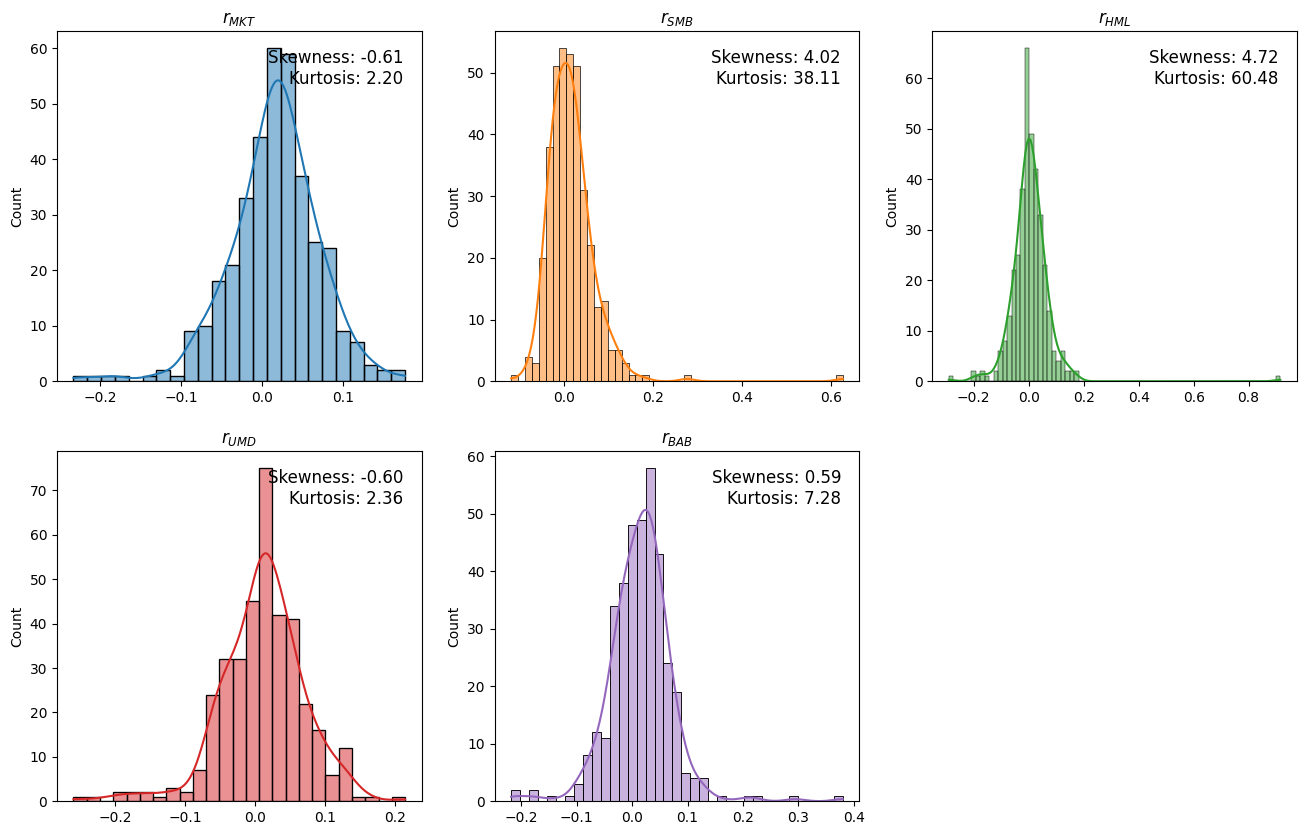

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Plotting histograms and adding skewness and kurtosis
ret = r
factors = ret.columns
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, (factor, color) in enumerate(zip(factors, colors)):
    ax = axes[i // 3, i % 3]
    sns.histplot(ret[factor], kde=True, ax=ax, color=color)
    ax.set_title(rf'$r_{{{{{factor}}}}}$')
    skewness = skew(ret[factor].dropna())
    kurt = kurtosis(ret[factor].dropna())
    ax.text(0.95, 0.95, f'Skewness: {skewness:.2f}\nKurtosis: {kurt:.2f}', 
            transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right')
    ax.set_xlabel('') 

# Hide the last empty plot
if len(factors) < 6:
    for j in range(len(factors), 6):
        axes[j // 3, j % 3].axis('off')

plt.savefig('Plots/appendix-histograms_orginal_factors.png', dpi=300, bbox_inches='tight')
plt.show()

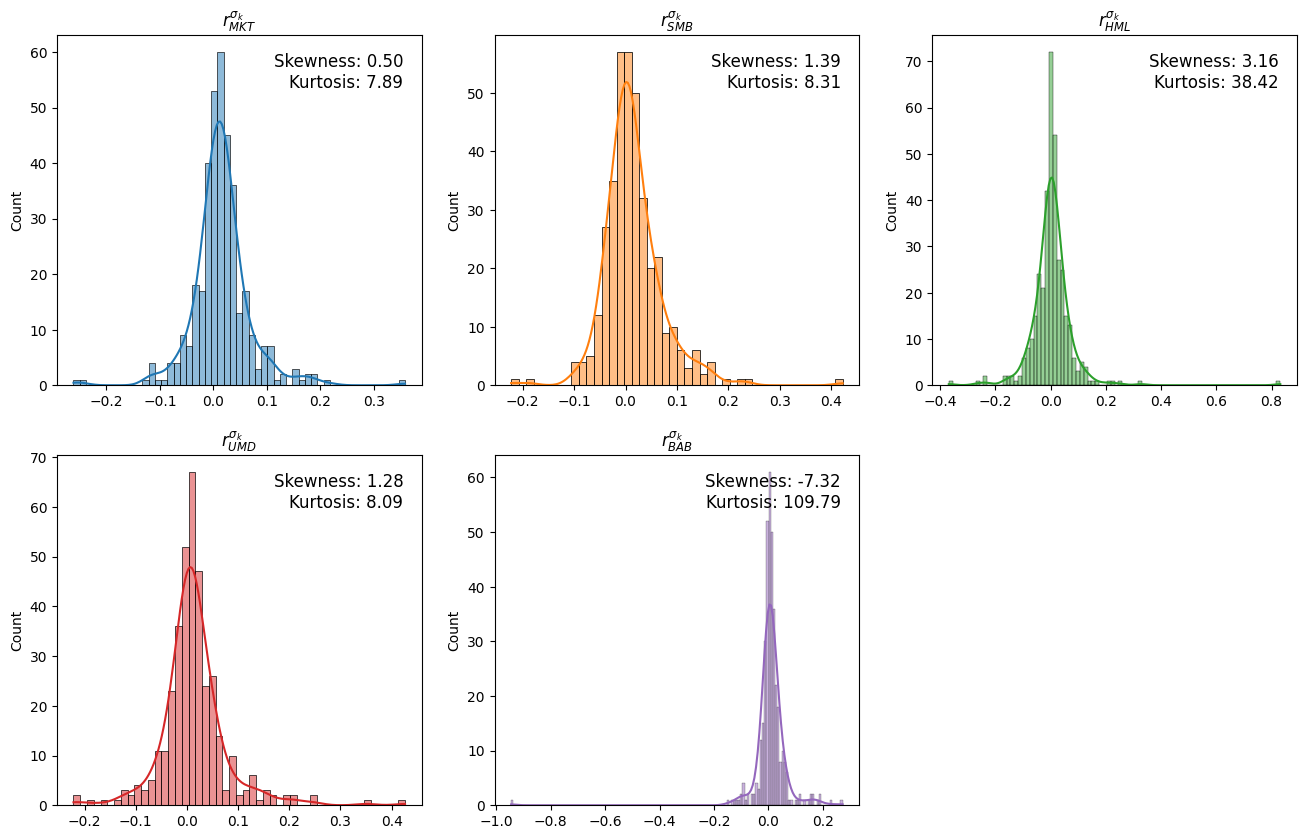

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Plotting histograms and adding skewness and kurtosis
ret = r_sigma_k
factors = ret.columns
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, (factor, color) in enumerate(zip(factors, colors)):
    ax = axes[i // 3, i % 3]
    sns.histplot(ret[factor], kde=True, ax=ax, color=color)
    ax.set_title(rf'$r^{{\sigma_{{k}}}}_{{{factor}}}$')
    skewness = skew(ret[factor].dropna())
    kurt = kurtosis(ret[factor].dropna())
    ax.text(0.95, 0.95, f'Skewness: {skewness:.2f}\nKurtosis: {kurt:.2f}', 
            transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right')
    ax.set_xlabel('')

# Hide the last empty plot
if len(factors) < 6:
    for j in range(len(factors), 6):
        axes[j // 3, j % 3].axis('off')

plt.savefig('Plots/appendix-histograms_individual_timed_factors_using_k.png', dpi=300, bbox_inches='tight')
plt.show()

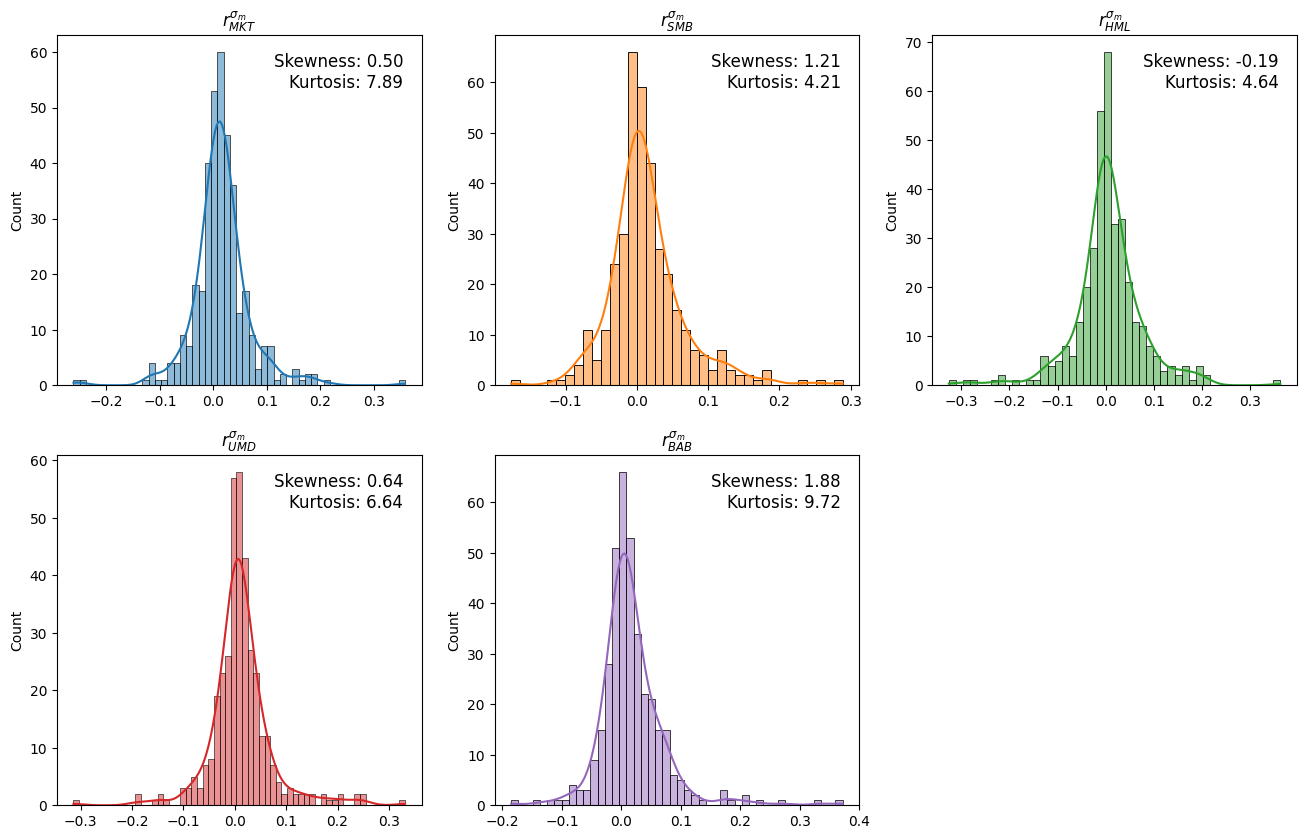

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Plotting histograms and adding skewness and kurtosis
ret = r_sigma_m
factors = ret.columns
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, (factor, color) in enumerate(zip(factors, colors)):
    ax = axes[i // 3, i % 3]
    sns.histplot(ret[factor], kde=True, ax=ax, color=color)
    ax.set_title(rf'$r^{{\sigma_{{m}}}}_{{{factor}}}$')
    skewness = skew(ret[factor].dropna())
    kurt = kurtosis(ret[factor].dropna())
    ax.text(0.95, 0.95, f'Skewness: {skewness:.2f}\nKurtosis: {kurt:.2f}', 
            transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right')
    ax.set_xlabel('')

# Hide the last empty plot
if len(factors) < 6:
    for j in range(len(factors), 6):
        axes[j // 3, j % 3].axis('off')

plt.savefig('Plots/appendix-histograms_individual_timed_factors_using_m.png', dpi=300, bbox_inches='tight')
plt.show()

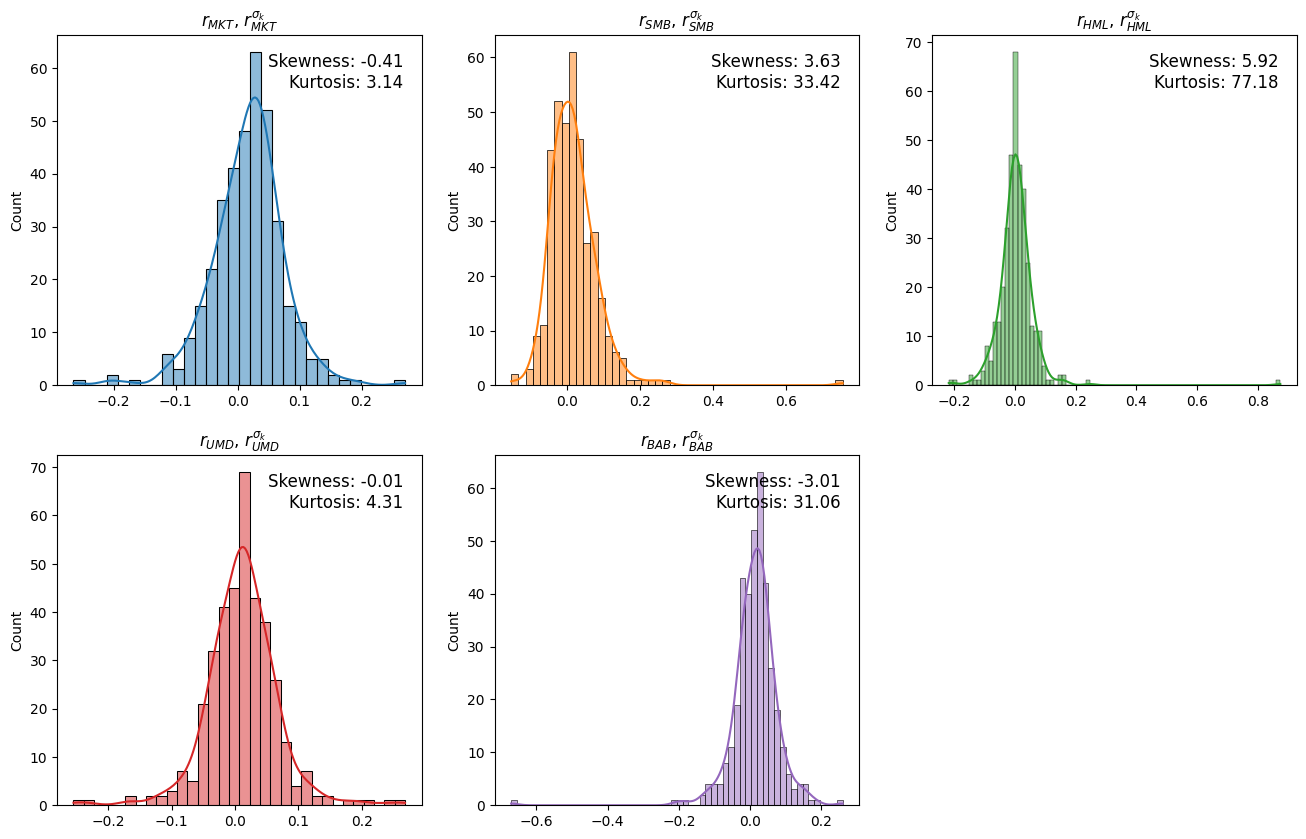

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Plotting histograms and adding skewness and kurtosis
ret = r_sigma_k_ptf
factors = ret.columns
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, (factor, color) in enumerate(zip(factors, colors)):
    ax = axes[i // 3, i % 3]
    sns.histplot(ret[factor], kde=True, ax=ax, color=color)
    ax.set_title(rf'$r_{{{factor}}}$, $r^{{\sigma_{{k}}}}_{{{factor}}}$')
    skewness = skew(ret[factor].dropna())
    kurt = kurtosis(ret[factor].dropna())
    ax.text(0.95, 0.95, f'Skewness: {skewness:.2f}\nKurtosis: {kurt:.2f}', 
            transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right')
    ax.set_xlabel('')

# Hide the last empty plot
if len(factors) < 6:
    for j in range(len(factors), 6):
        axes[j // 3, j % 3].axis('off')

plt.savefig('Plots/appendix-histograms_individual_timed_factor_ptf_using_k.png', dpi=300, bbox_inches='tight')
plt.show()

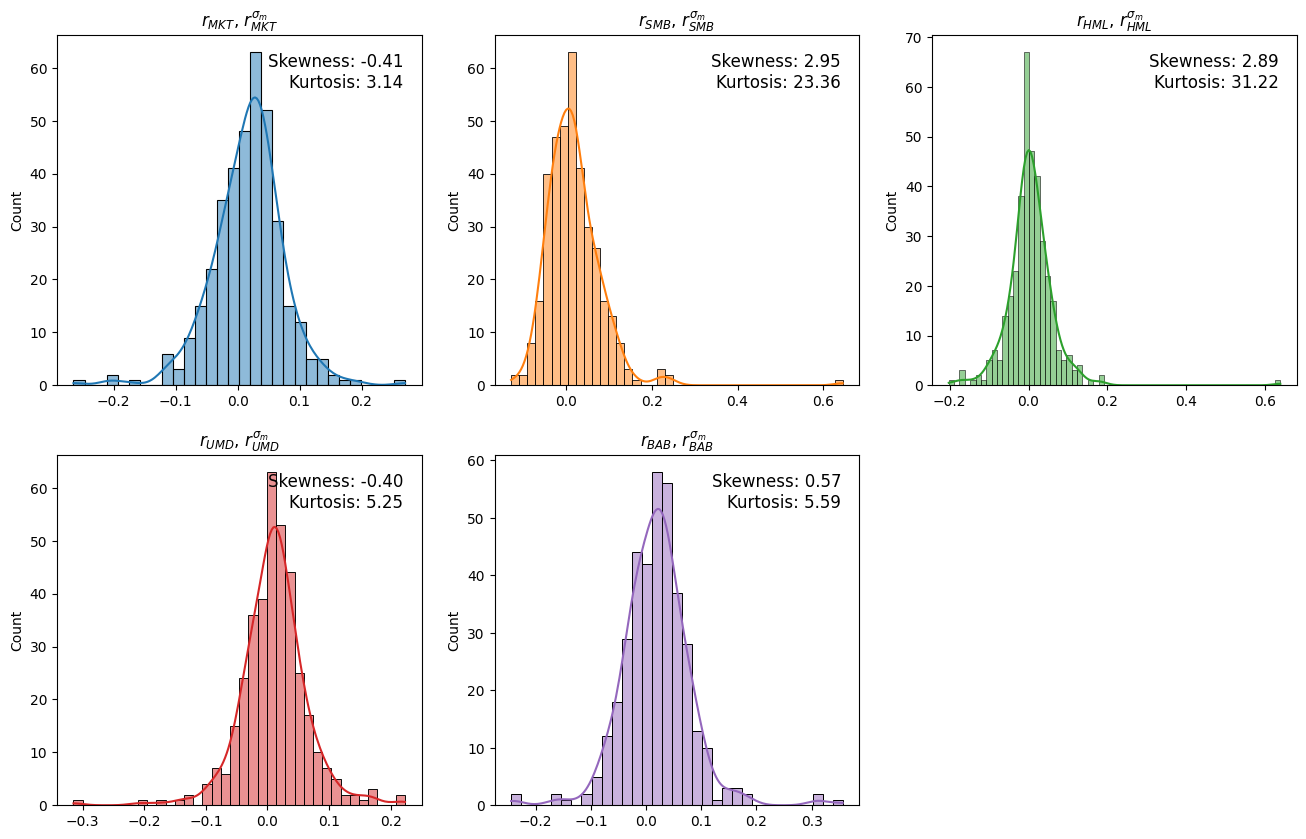

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Plotting histograms and adding skewness and kurtosis
ret = r_sigma_m_ptf
factors = ret.columns
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, (factor, color) in enumerate(zip(factors, colors)):
    ax = axes[i // 3, i % 3]
    sns.histplot(ret[factor], kde=True, ax=ax, color=color)
    ax.set_title(rf'$r_{{{factor}}}$, $r^{{\sigma_{{m}}}}_{{{factor}}}$')
    skewness = skew(ret[factor].dropna())
    kurt = kurtosis(ret[factor].dropna())
    ax.text(0.95, 0.95, f'Skewness: {skewness:.2f}\nKurtosis: {kurt:.2f}', 
            transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right')
    ax.set_xlabel('')

# Hide the last empty plot
if len(factors) < 6:
    for j in range(len(factors), 6):
        axes[j // 3, j % 3].axis('off')

plt.savefig('Plots/appendix-histograms_individual_timed_factor_ptf_using_m.png', dpi=300, bbox_inches='tight')
plt.show()

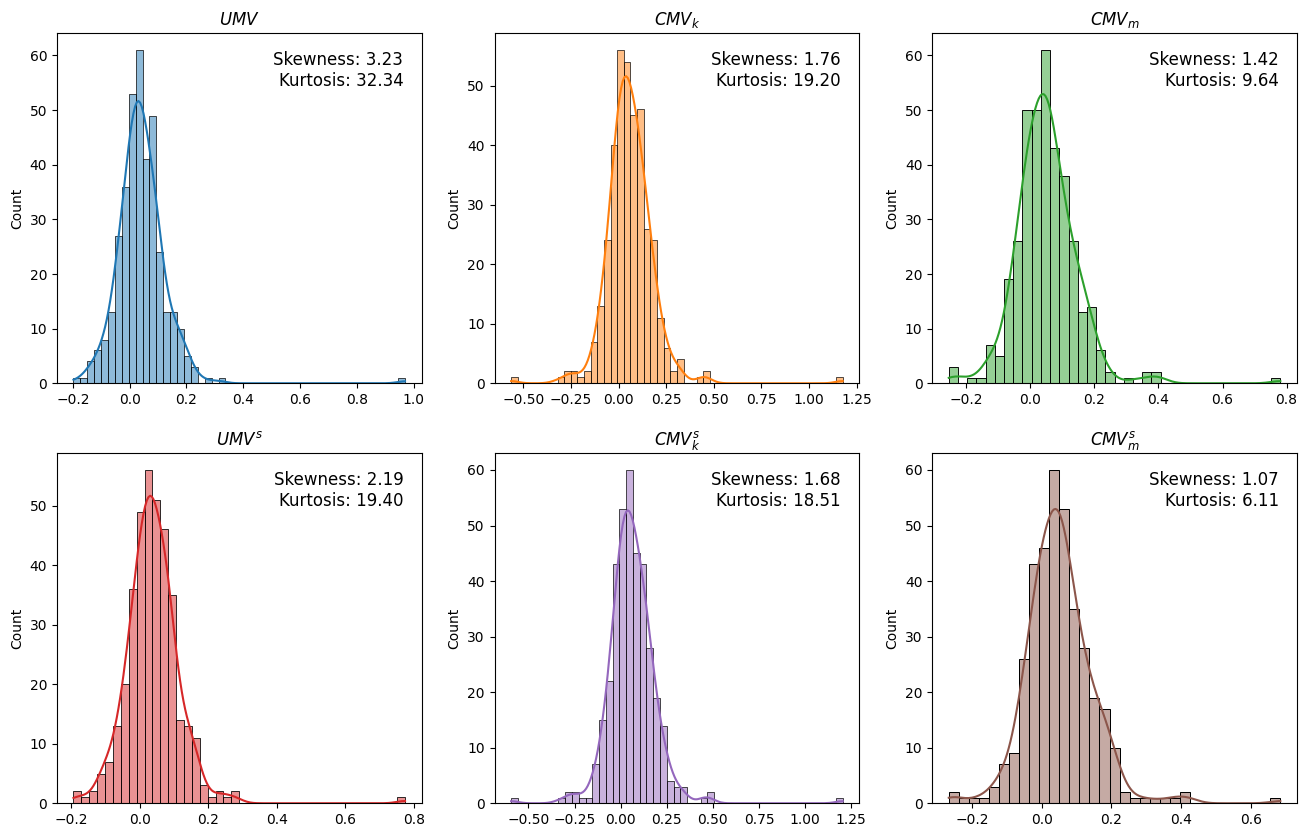

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Plotting histograms and adding skewness and kurtosis
ret = MV
factors = ret.columns
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, (factor, color) in enumerate(zip(factors, colors)):
    ax = axes[i // 3, i % 3]
    sns.histplot(ret[factor], kde=True, ax=ax, color=color)
    ax.set_title(rf'${factor}$')
    skewness = skew(ret[factor].dropna())
    kurt = kurtosis(ret[factor].dropna())
    ax.text(0.95, 0.95, f'Skewness: {skewness:.2f}\nKurtosis: {kurt:.2f}', 
            transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right')
    ax.set_xlabel('')

# Hide the last empty plot
if len(factors) < 6:
    for j in range(len(factors), 6):
        axes[j // 3, j % 3].axis('off')

plt.savefig('Plots/appendix-histograms_MV.png', dpi=300, bbox_inches='tight')
plt.show()

## Drawdowns

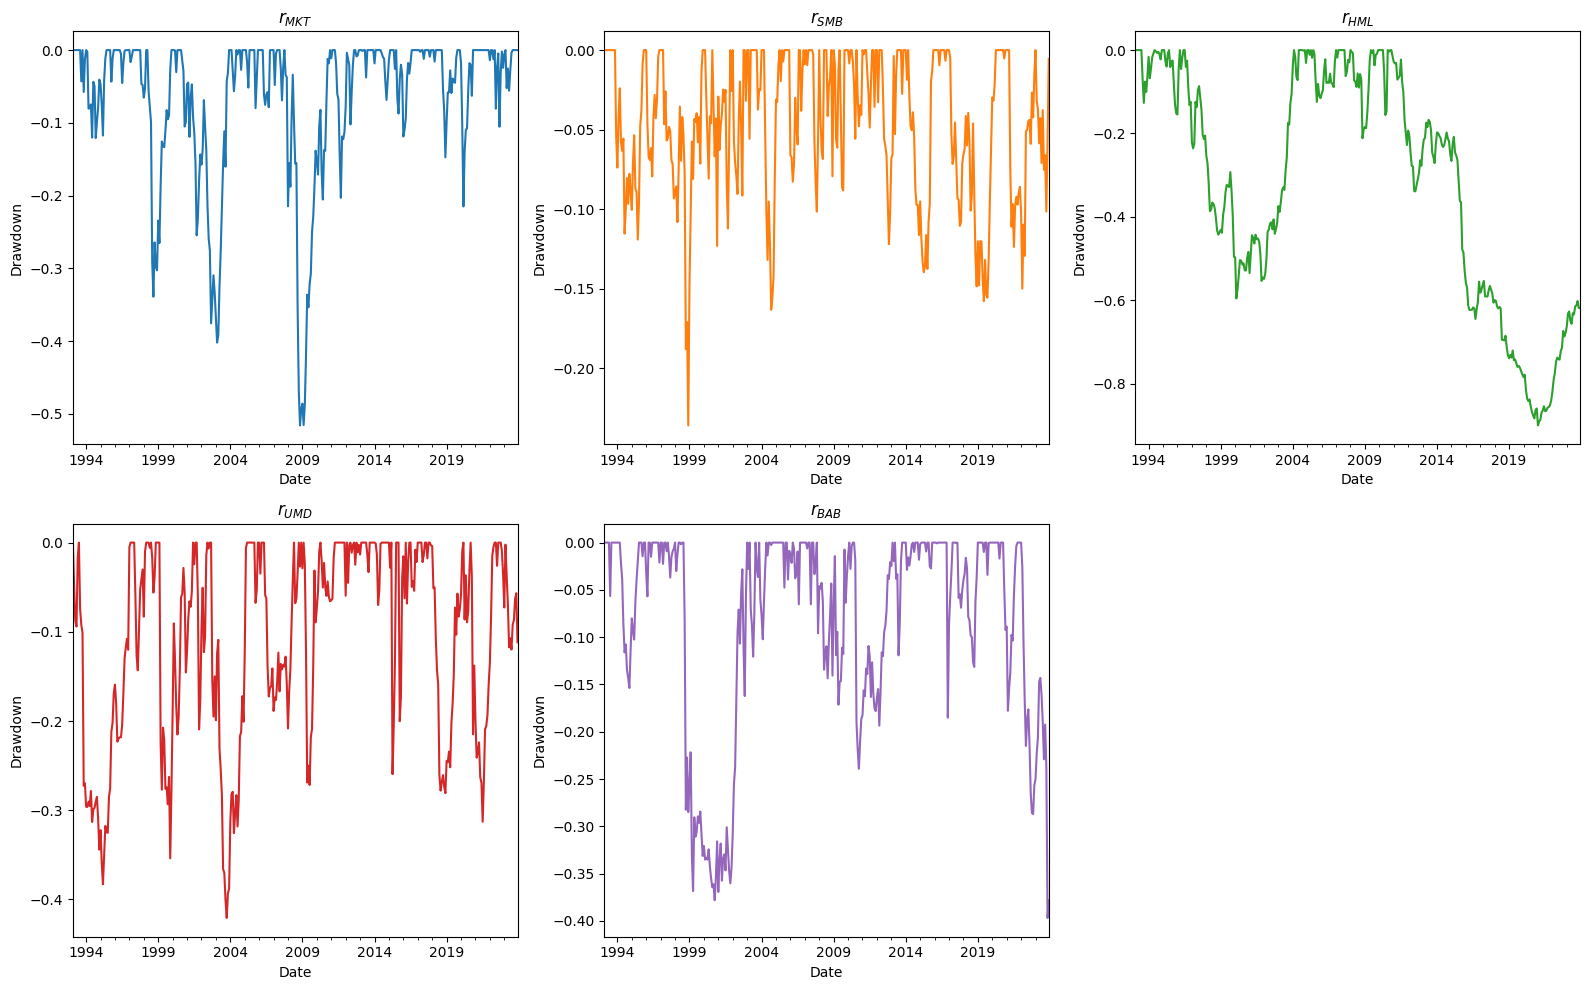

In [20]:
### Function to calculate and plot drawdowns
def plot_drawdowns(returns, ax=None, color='blue'):
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak

    if ax is None:
        ax = plt.gca()
    drawdown.plot(ax=ax, color=color)
    ax.set_ylabel('Drawdown')
    ax.set_xlabel('Date')

### Plotting drawdowns
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Plotting drawdowns
ret = r
factors = ret.columns
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, (factor, color) in enumerate(zip(factors, colors)):
    ax = axes[i // 3, i % 3]
    plot_drawdowns(ret[factor], ax=ax, color=color)
    ax.set_title(rf'$r_{{{{{factor}}}}}$')

# Hide the last empty plot
if len(factors) < 6:
    for j in range(len(factors), 6):
        axes[j // 3, j % 3].axis('off')

plt.tight_layout()
plt.savefig('Plots/appendix-drawdowns_orginal_factors.png', dpi=300, bbox_inches='tight')
plt.show()

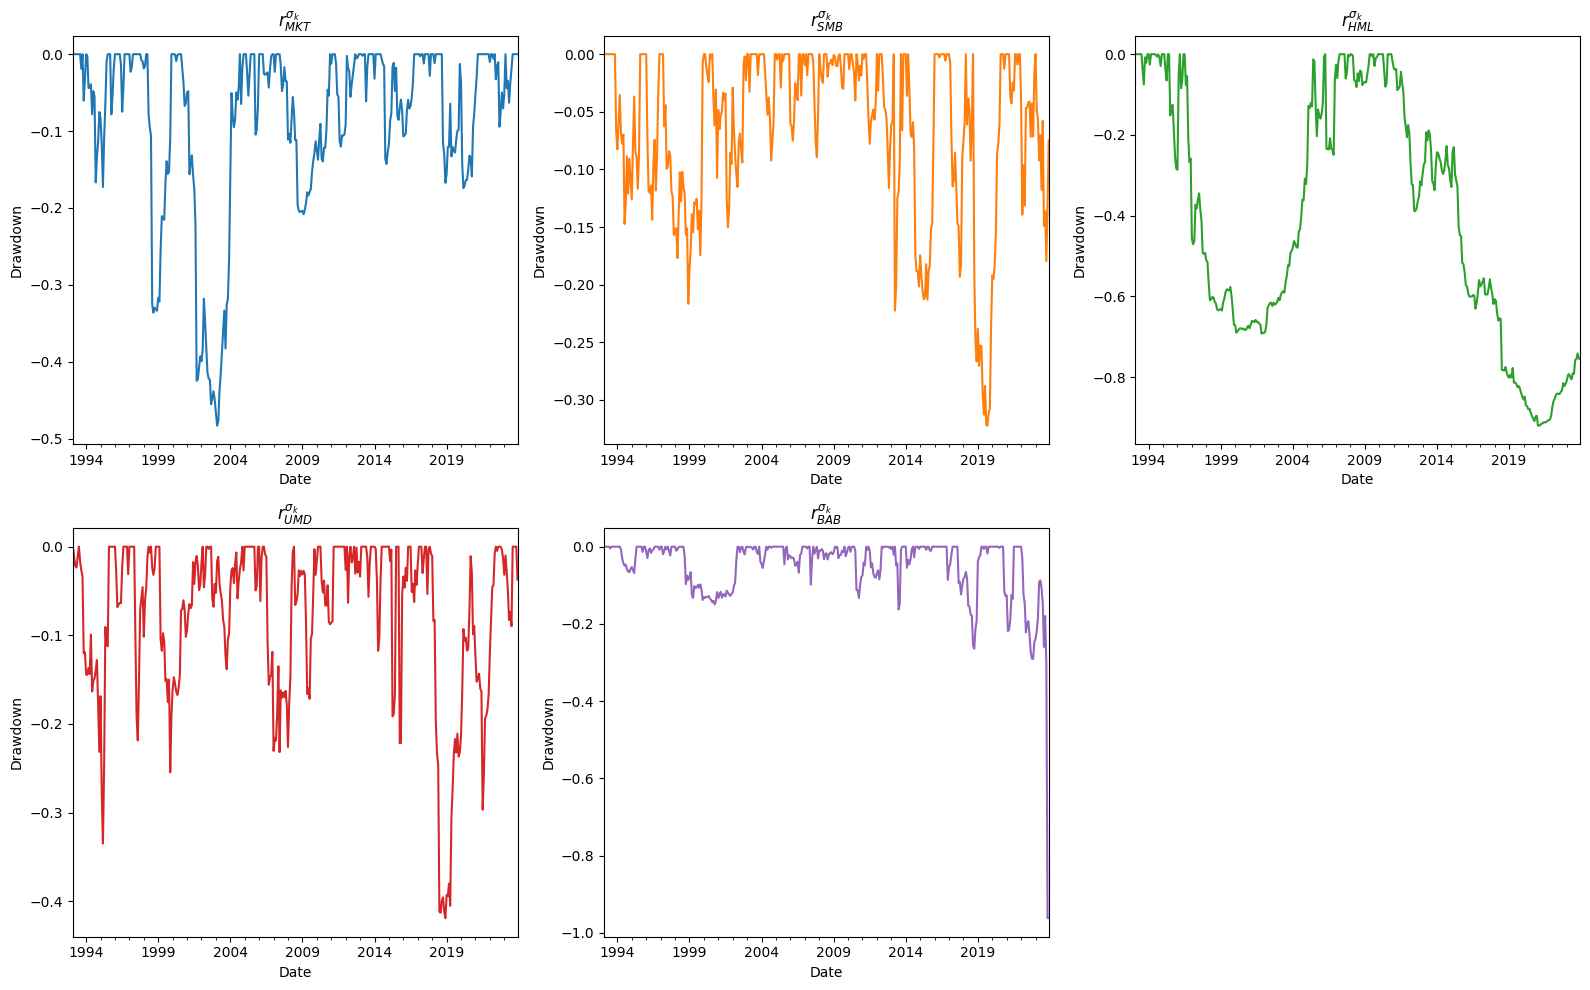

In [21]:
### Plotting drawdowns
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Plotting drawdowns
ret = r_sigma_k
factors = ret.columns
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, (factor, color) in enumerate(zip(factors, colors)):
    ax = axes[i // 3, i % 3]
    plot_drawdowns(ret[factor], ax=ax, color=color)
    ax.set_title(rf'$r^{{\sigma_{{k}}}}_{{{factor}}}$')

# Hide the last empty plot
if len(factors) < 6:
    for j in range(len(factors), 6):
        axes[j // 3, j % 3].axis('off')

plt.tight_layout()
plt.savefig('Plots/appendix-drawdowns_indvidual_managed_factors_with_k.png', dpi=300, bbox_inches='tight')
plt.show()

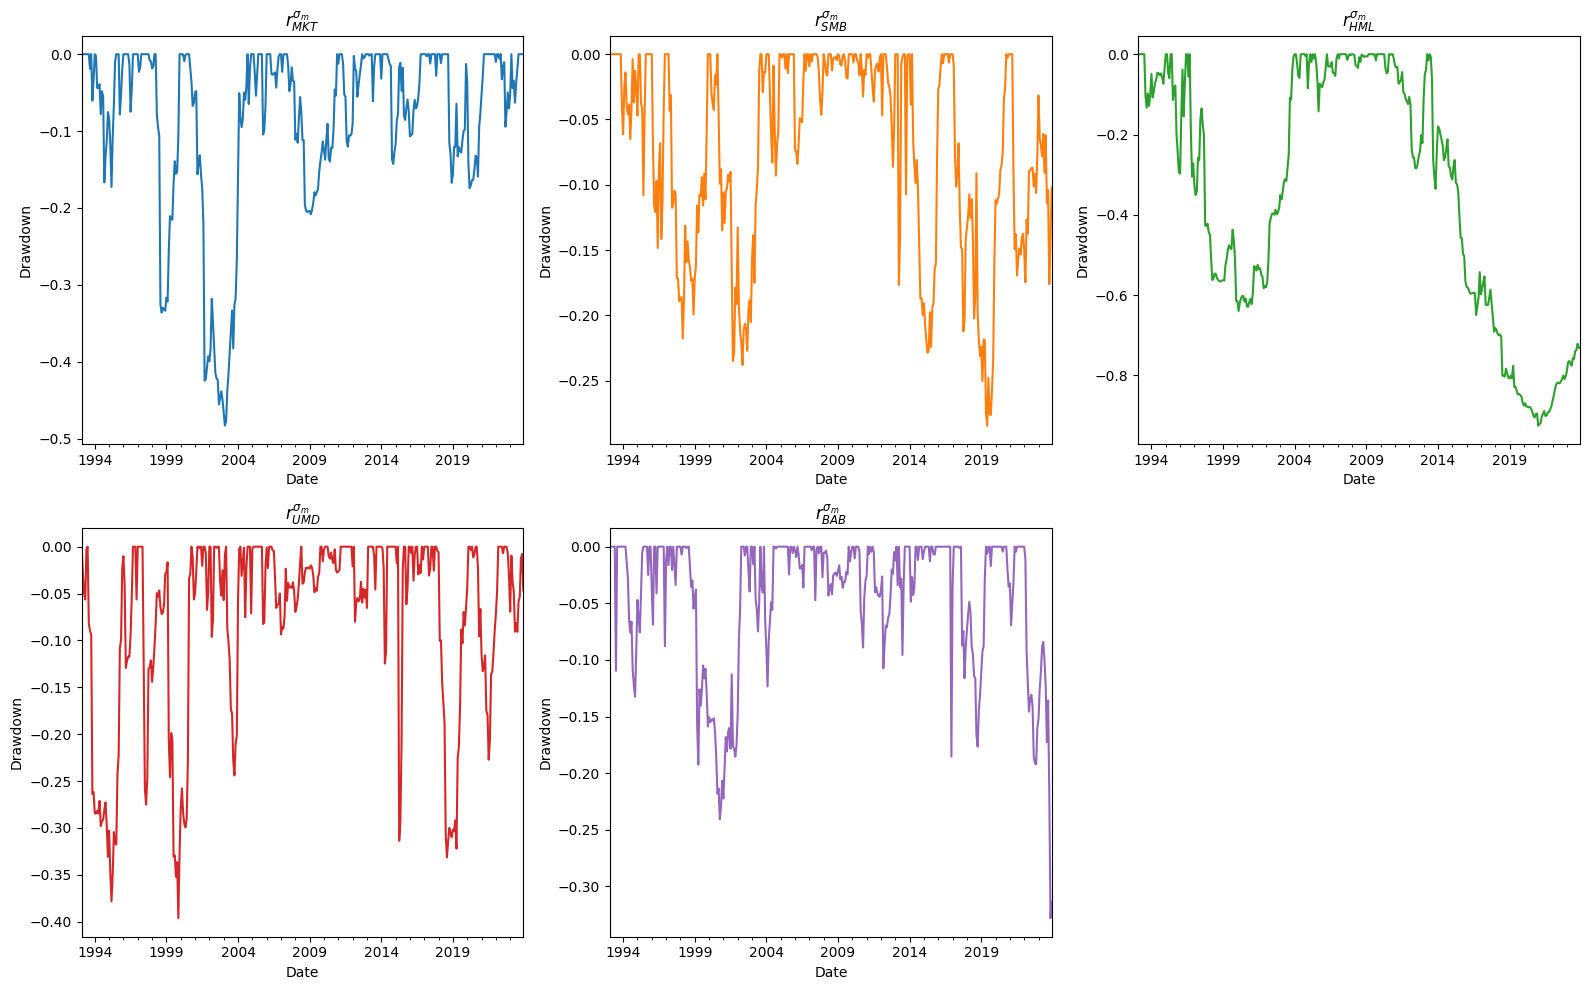

In [22]:
### Plotting drawdowns
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Plotting drawdowns
ret = r_sigma_m
factors = ret.columns
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, (factor, color) in enumerate(zip(factors, colors)):
    ax = axes[i // 3, i % 3]
    plot_drawdowns(ret[factor], ax=ax, color=color)
    ax.set_title(rf'$r^{{\sigma_{{m}}}}_{{{factor}}}$')

# Hide the last empty plot
if len(factors) < 6:
    for j in range(len(factors), 6):
        axes[j // 3, j % 3].axis('off')

plt.tight_layout()
plt.savefig('Plots/appendix-drawdowns_indvidual_managed_factors_with_m.png', dpi=300, bbox_inches='tight')
plt.show()

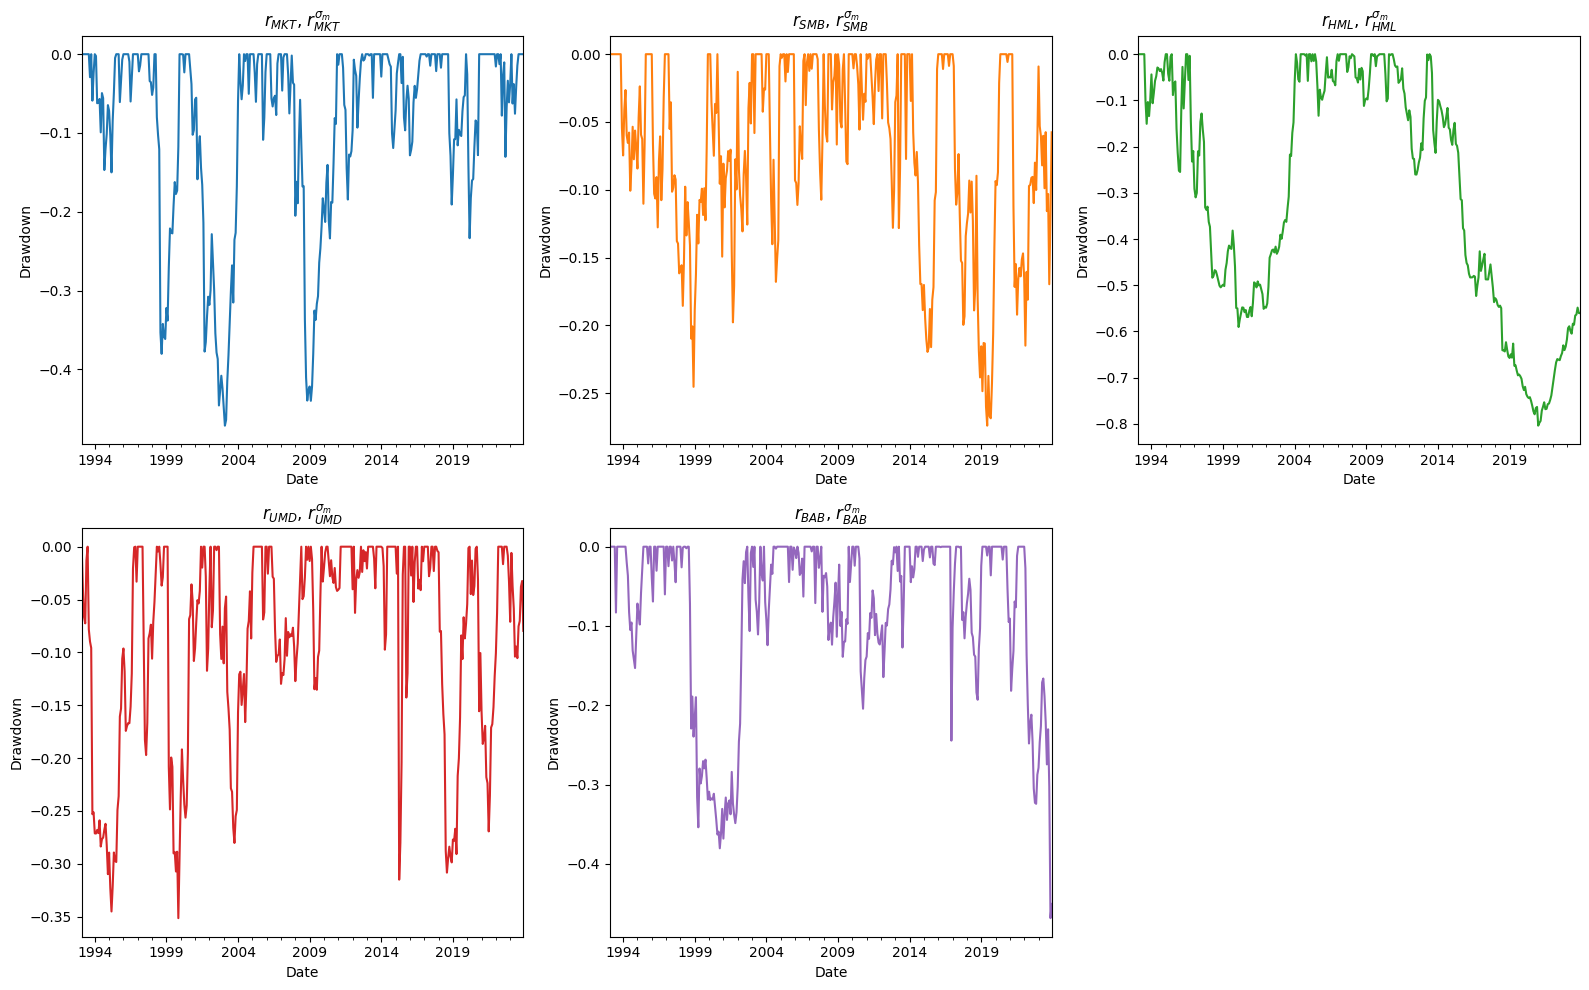

In [23]:
### Plotting drawdowns
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Plotting drawdowns
ret = r_sigma_m_ptf
factors = ret.columns
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, (factor, color) in enumerate(zip(factors, colors)):
    ax = axes[i // 3, i % 3]
    plot_drawdowns(ret[factor], ax=ax, color=color)
    ax.set_title(rf'$r_{{{factor}}}$, $r^{{\sigma_{{m}}}}_{{{factor}}}$')

# Hide the last empty plot
if len(factors) < 6:
    for j in range(len(factors), 6):
        axes[j // 3, j % 3].axis('off')

plt.tight_layout()
plt.savefig('Plots/appendix-drawdowns_indvidual_managed_ptf_factors_with_m.png', dpi=300, bbox_inches='tight')
plt.show()

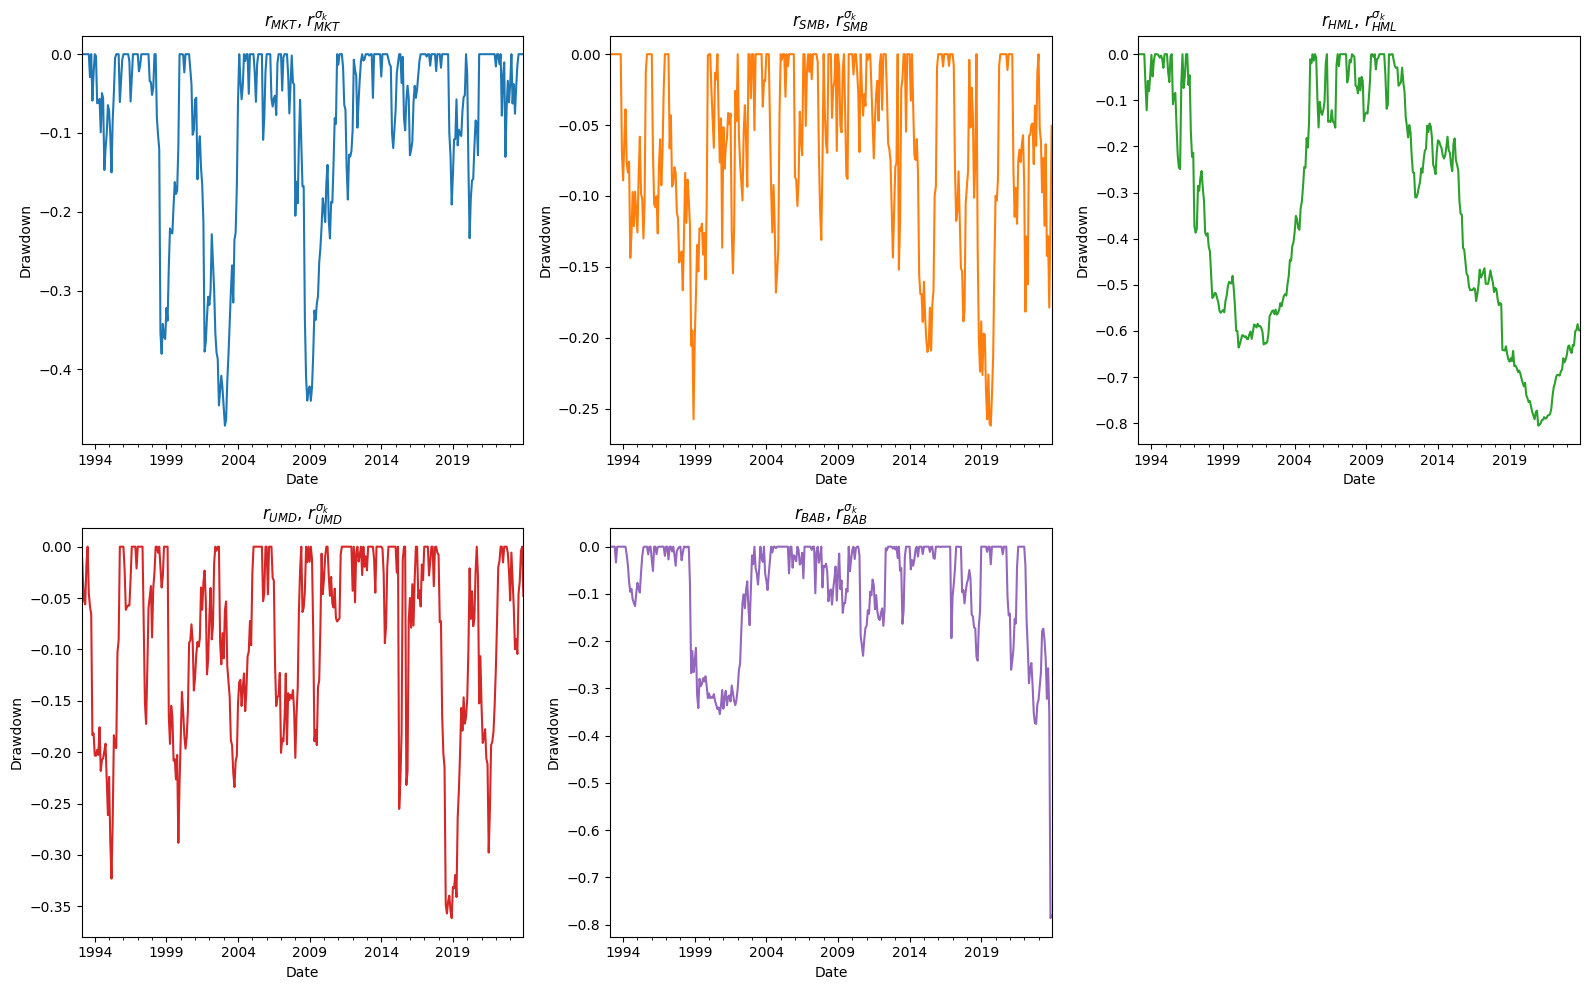

In [24]:
### Plotting drawdowns
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Plotting drawdowns
ret = r_sigma_k_ptf
factors = ret.columns
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, (factor, color) in enumerate(zip(factors, colors)):
    ax = axes[i // 3, i % 3]
    plot_drawdowns(ret[factor], ax=ax, color=color)
    ax.set_title(rf'$r_{{{factor}}}$, $r^{{\sigma_{{k}}}}_{{{factor}}}$')

# Hide the last empty plot
if len(factors) < 6:
    for j in range(len(factors), 6):
        axes[j // 3, j % 3].axis('off')

plt.tight_layout()
plt.savefig('Plots/appendix-drawdowns_indvidual_managed_ptf_factors_with_k.png', dpi=300, bbox_inches='tight')
plt.show()

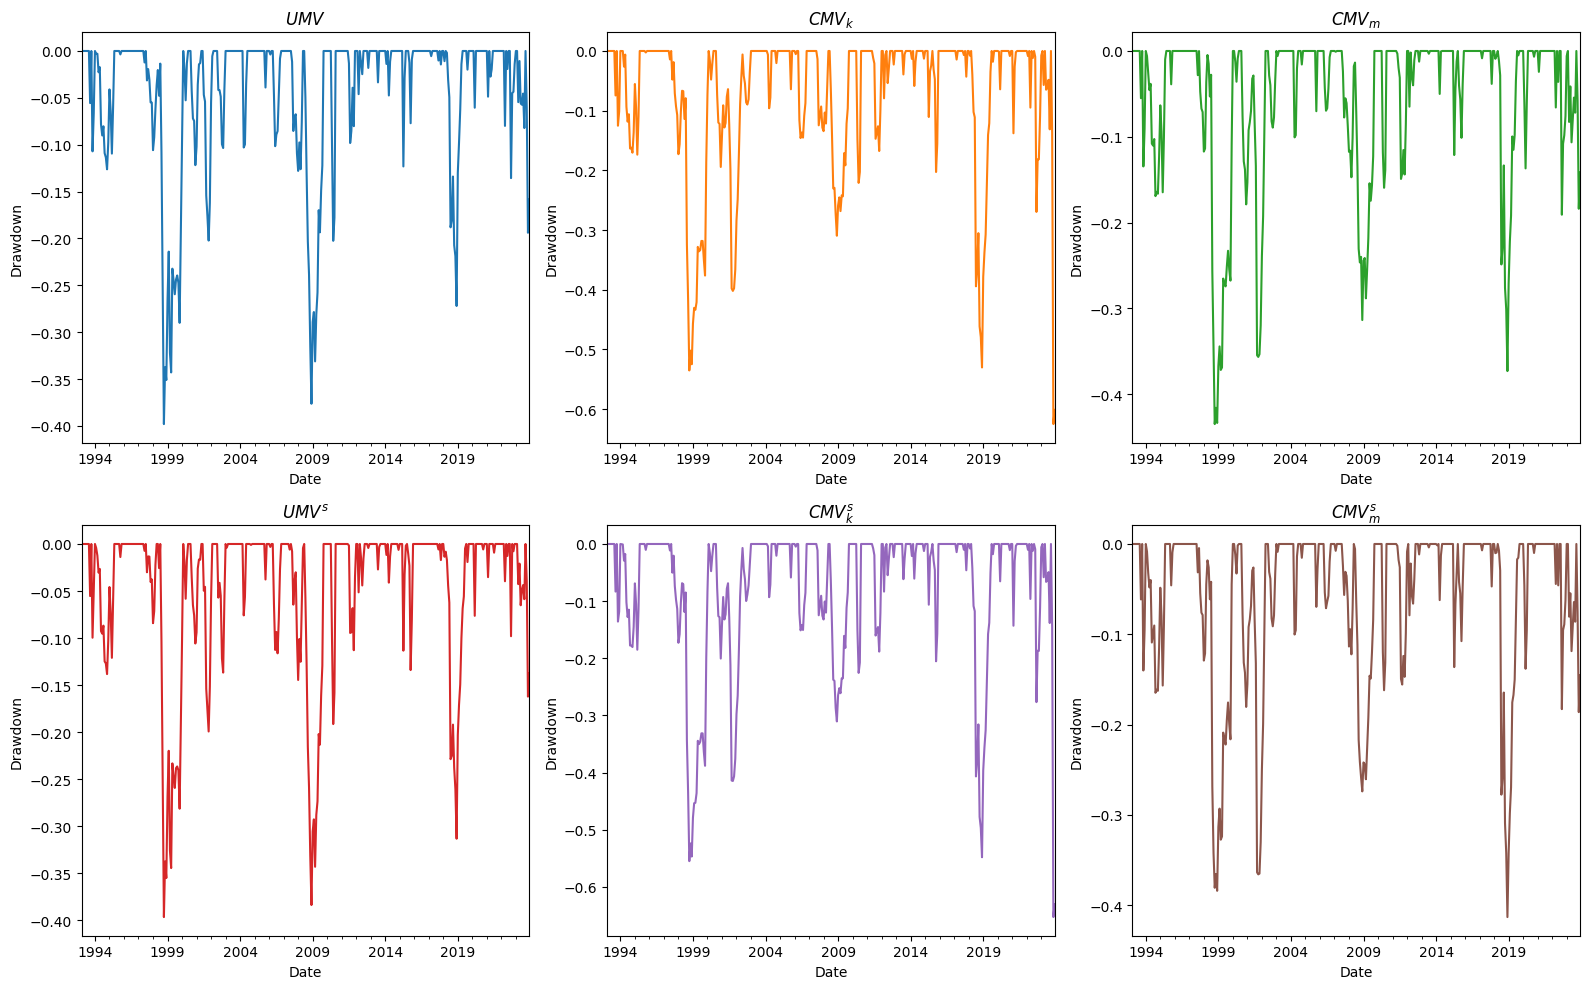

In [25]:
### Plotting drawdowns
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Plotting drawdowns
ret = MV
factors = ret.columns
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, (factor, color) in enumerate(zip(factors, colors)):
    ax = axes[i // 3, i % 3]
    plot_drawdowns(ret[factor], ax=ax, color=color)
    ax.set_title(rf'${factor}$')

# Hide the last empty plot
if len(factors) < 6:
    for j in range(len(factors), 6):
        axes[j // 3, j % 3].axis('off')

plt.tight_layout()
plt.savefig('Plots/appendix-drawdowns_MV.png', dpi=300, bbox_inches='tight')
plt.show()

## Correlations

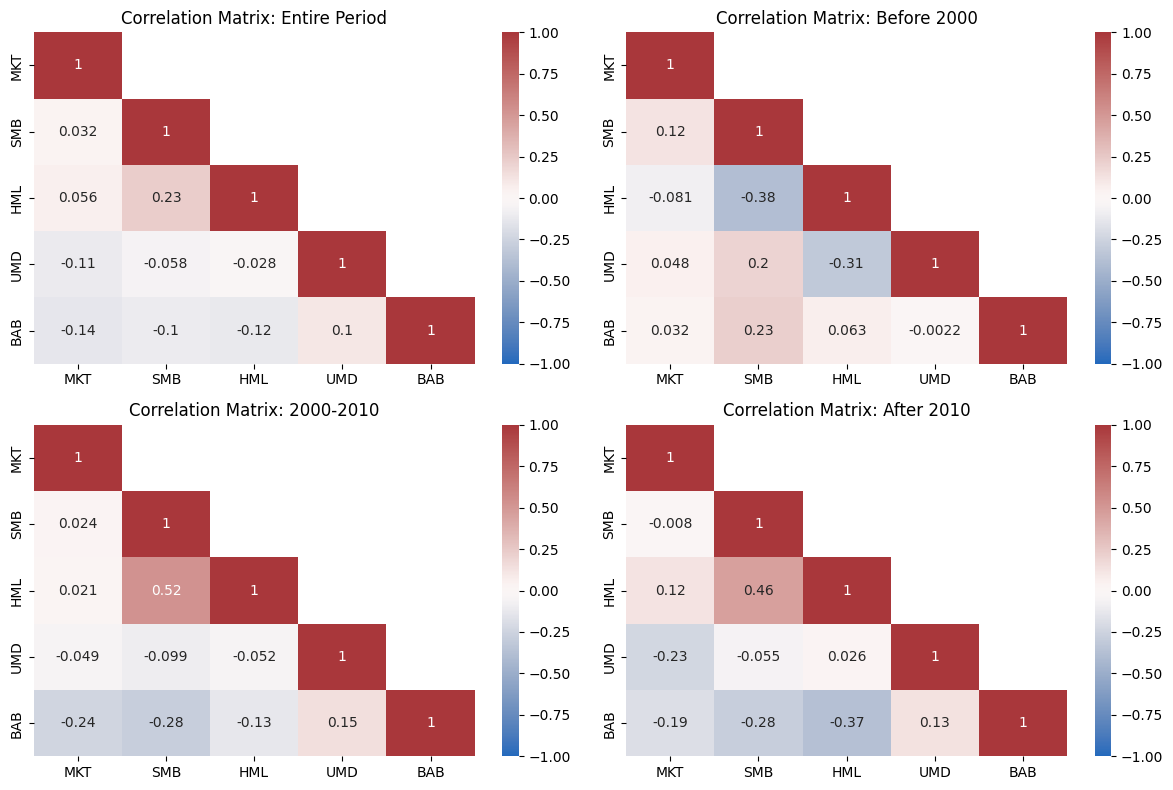

In [26]:
ret = r

# Define the periods
periods = {
    'Entire Period': ret.index,
    'Before 2000': ret.loc[:'2000'].index,
    '2000-2010': ret.loc['2000':'2010'].index,
    'After 2010': ret.loc['2010':].index
}

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot correlation matrices for each period
for ax, (title, idx) in zip(axes.flatten(), periods.items()):
    corr = ret.loc[idx].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    sns.heatmap(corr, annot=True, cmap='vlag', vmin=-1, vmax=1, ax=ax, mask=mask)
    ax.set_title(f'Correlation Matrix: {title}')

plt.tight_layout()
plt.savefig('Plots/appendix-corrmatrix.png', dpi=300, bbox_inches='tight')
plt.show()

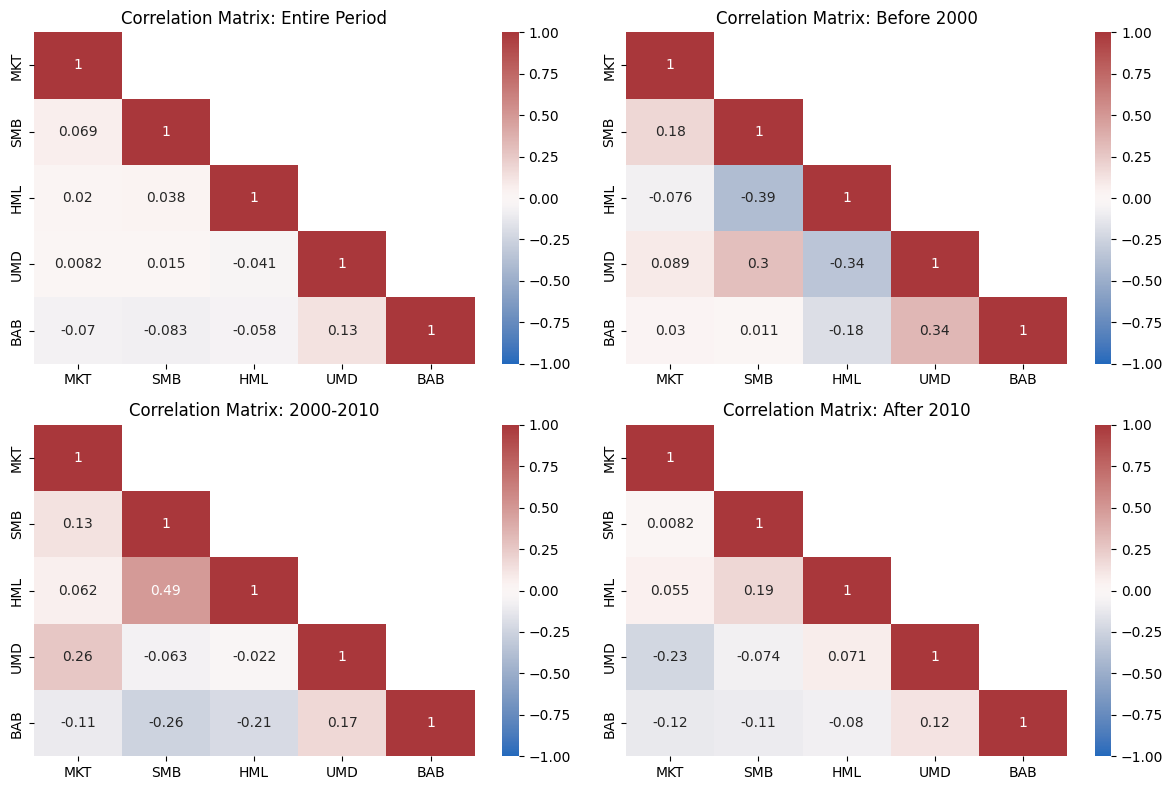

In [27]:
ret = r_sigma_k

# Define the periods
periods = {
    'Entire Period': ret.index,
    'Before 2000': ret.loc[:'2000'].index,
    '2000-2010': ret.loc['2000':'2010'].index,
    'After 2010': ret.loc['2010':].index
}

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot correlation matrices for each period
for ax, (title, idx) in zip(axes.flatten(), periods.items()):
    corr = ret.loc[idx].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    sns.heatmap(corr, annot=True, cmap='vlag', vmin=-1, vmax=1, ax=ax, mask=mask)
    ax.set_title(f'Correlation Matrix: {title}')

plt.tight_layout()
plt.savefig('Plots/appendix-corrmatrix_r_sigma_k.png', dpi=300, bbox_inches='tight')
plt.show()

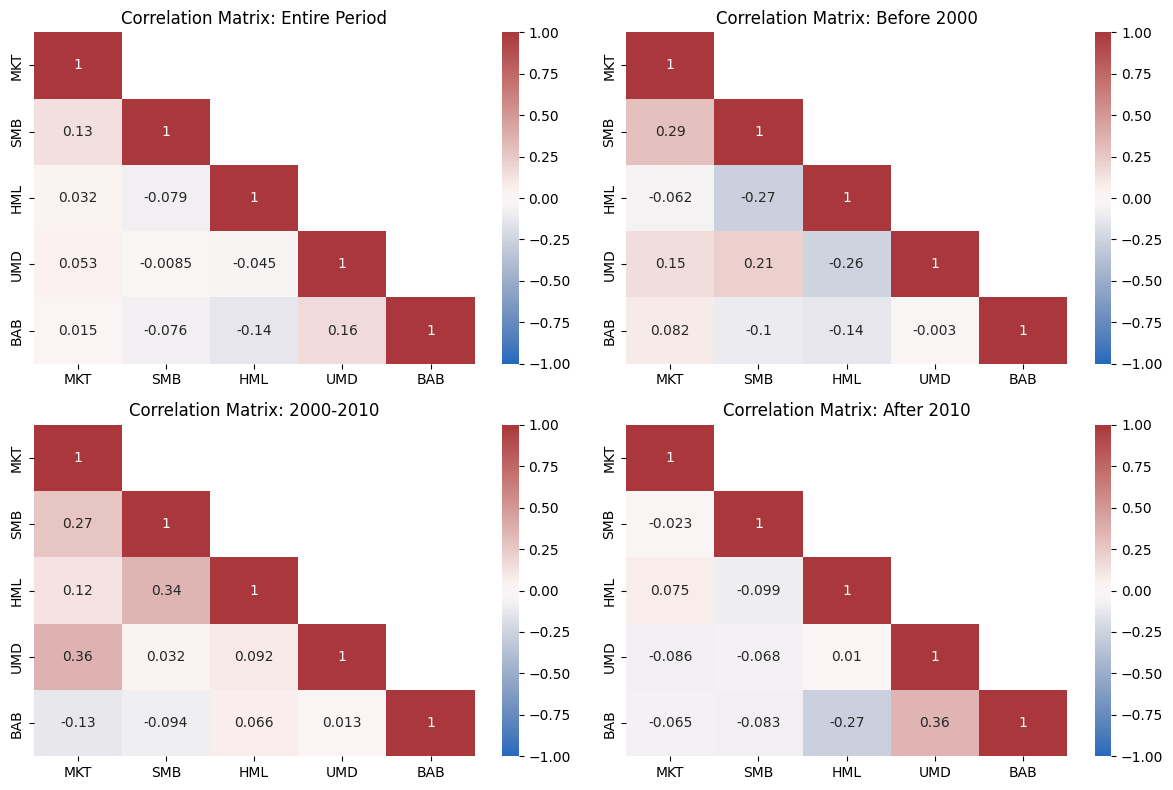

In [28]:
ret = r_sigma_m

# Define the periods
periods = {
    'Entire Period': ret.index,
    'Before 2000': ret.loc[:'2000'].index,
    '2000-2010': ret.loc['2000':'2010'].index,
    'After 2010': ret.loc['2010':].index
}

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot correlation matrices for each period
for ax, (title, idx) in zip(axes.flatten(), periods.items()):
    corr = ret.loc[idx].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    sns.heatmap(corr, annot=True, cmap='vlag', vmin=-1, vmax=1, ax=ax, mask=mask)
    ax.set_title(f'Correlation Matrix: {title}')

plt.tight_layout()
plt.savefig('Plots/appendix-corrmatrix_r_sigma_m.png', dpi=300, bbox_inches='tight')
plt.show()

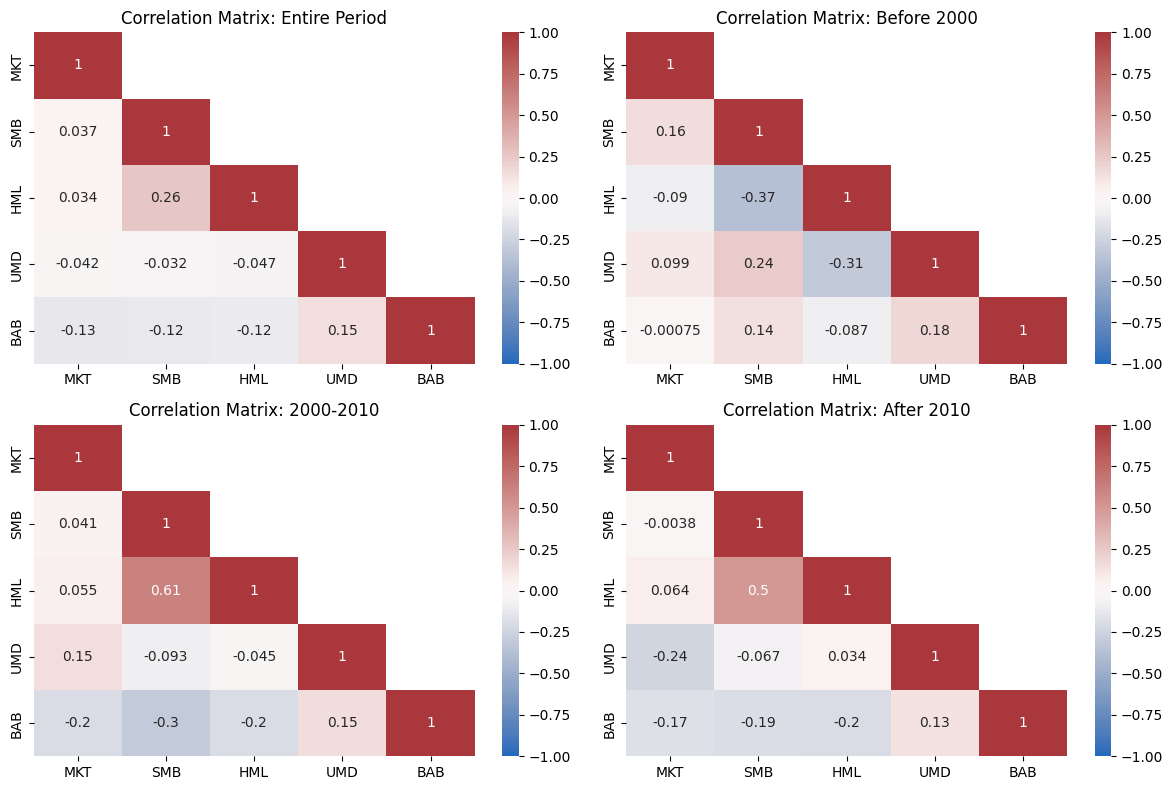

In [29]:
ret = r_sigma_k_ptf

# Define the periods
periods = {
    'Entire Period': ret.index,
    'Before 2000': ret.loc[:'2000'].index,
    '2000-2010': ret.loc['2000':'2010'].index,
    'After 2010': ret.loc['2010':].index
}

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot correlation matrices for each period
for ax, (title, idx) in zip(axes.flatten(), periods.items()):
    corr = ret.loc[idx].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    sns.heatmap(corr, annot=True, cmap='vlag', vmin=-1, vmax=1, ax=ax, mask=mask)
    ax.set_title(f'Correlation Matrix: {title}')

plt.tight_layout()
plt.savefig('Plots/appendix-corrmatrix_r_sigma_k_ptf.png', dpi=300, bbox_inches='tight')
plt.show()

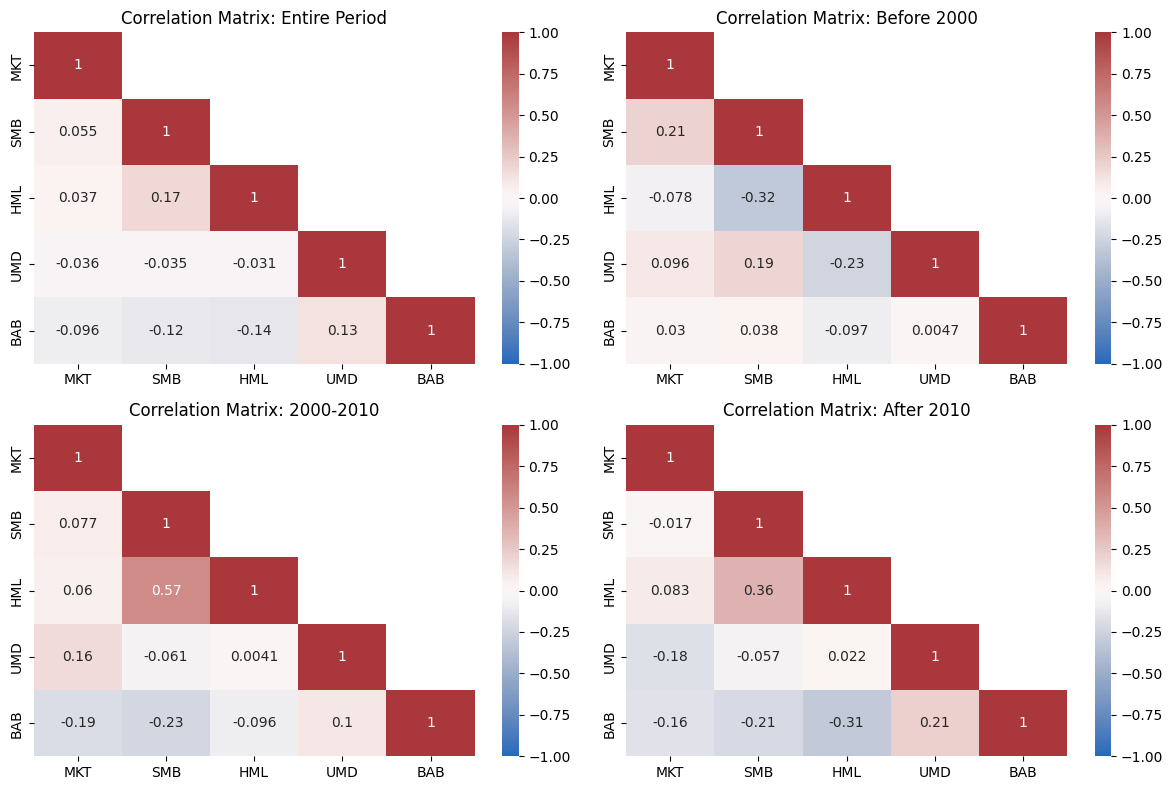

In [30]:
ret = r_sigma_m_ptf

# Define the periods
periods = {
    'Entire Period': ret.index,
    'Before 2000': ret.loc[:'2000'].index,
    '2000-2010': ret.loc['2000':'2010'].index,
    'After 2010': ret.loc['2010':].index
}

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot correlation matrices for each period
for ax, (title, idx) in zip(axes.flatten(), periods.items()):
    corr = ret.loc[idx].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    sns.heatmap(corr, annot=True, cmap='vlag', vmin=-1, vmax=1, ax=ax, mask=mask)
    ax.set_title(f'Correlation Matrix: {title}')

plt.tight_layout()
plt.savefig('Plots/appendix-corrmatrix_r_sigma_m_ptf.png', dpi=300, bbox_inches='tight')
plt.show()

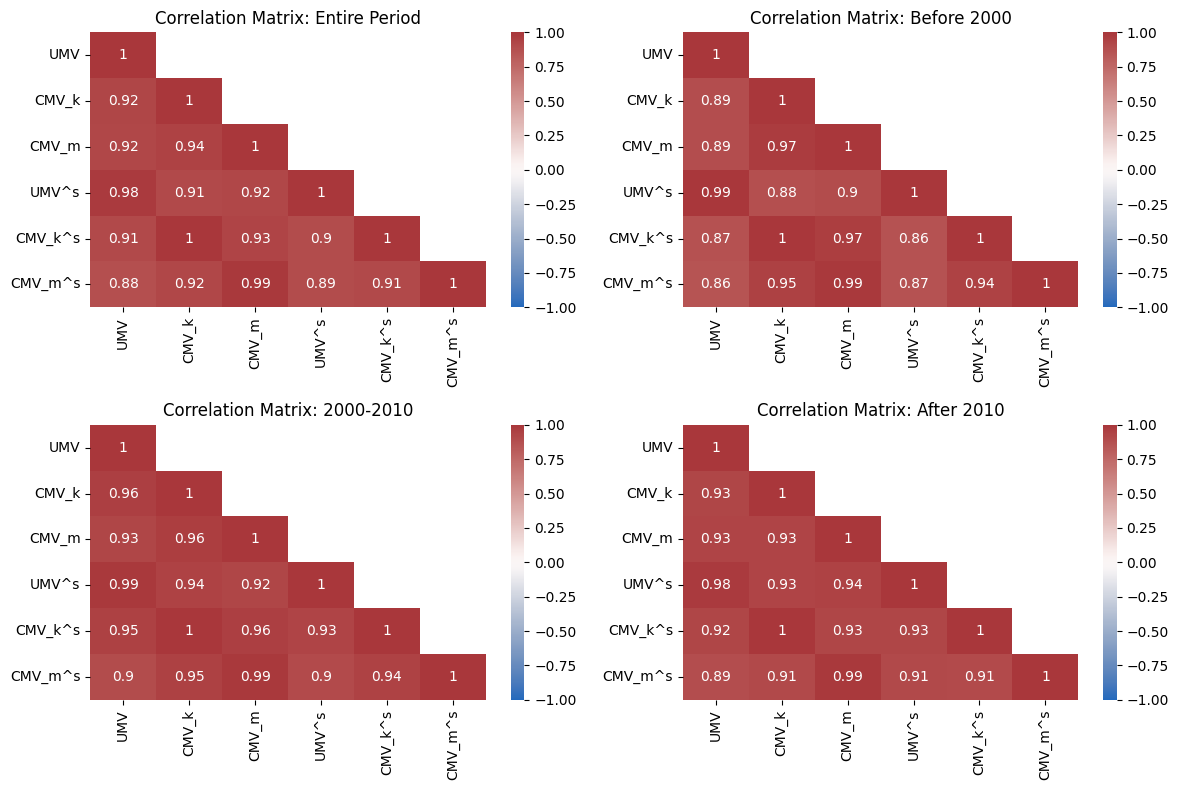

In [31]:
ret = MV

# Define the periods
periods = {
    'Entire Period': ret.index,
    'Before 2000': ret.loc[:'2000'].index,
    '2000-2010': ret.loc['2000':'2010'].index,
    'After 2010': ret.loc['2010':].index
}

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot correlation matrices for each period
for ax, (title, idx) in zip(axes.flatten(), periods.items()):
    corr = ret.loc[idx].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    sns.heatmap(corr, annot=True, cmap='vlag', vmin=-1, vmax=1, ax=ax, mask=mask)
    ax.set_title(f'Correlation Matrix: {title}')

plt.tight_layout()
plt.savefig('Plots/appendix-corrmatrix_MV.png', dpi=300, bbox_inches='tight')
plt.show()

## Cumulative Returns

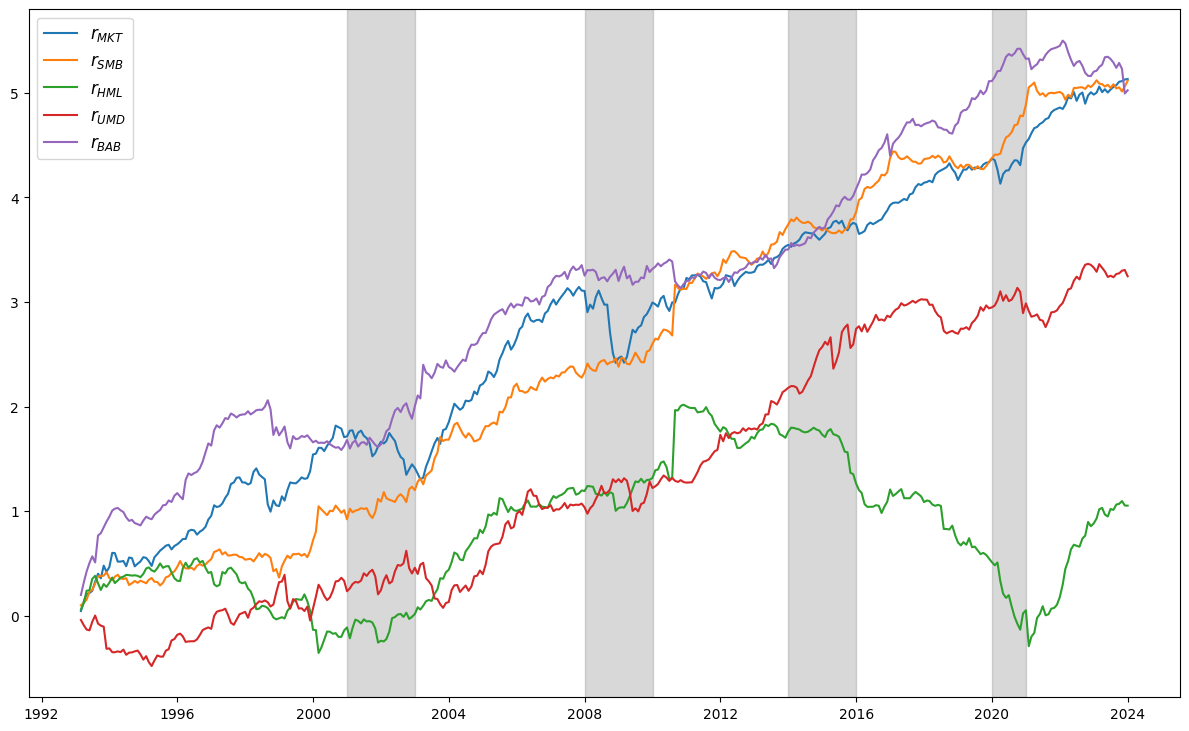

In [32]:
fig, axes = plt.subplots(1, 1, figsize=(12, 12/1.618))

ret = np.log(1 + r)

# Plotting cumulative returns for the entire period
for factor in ret.columns:
    axes.plot((ret[factor].cumsum()), label=rf'$r_{{{{{factor}}}}}$')

# Define the recession periods
recessions = [
    ('2001-01-01', '2003-01-01'),  # Dot-com bubble and global slowdown
    ('2008-01-01', '2010-01-01'),  # Global financial crisis
    ('2014-01-01', '2016-01-01'),  # Oil price collapse
    ('2020-01-01', '2020-12-31'),  # COVID-19 pandemic
]

# Plot recession periods in grey
for start, end in recessions:
    axes.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='grey', alpha=0.3)

axes.legend(fontsize='large')
plt.tight_layout()
plt.savefig('Plots/appendix-cum_ret_r.png', dpi=300, bbox_inches='tight')
plt.show()

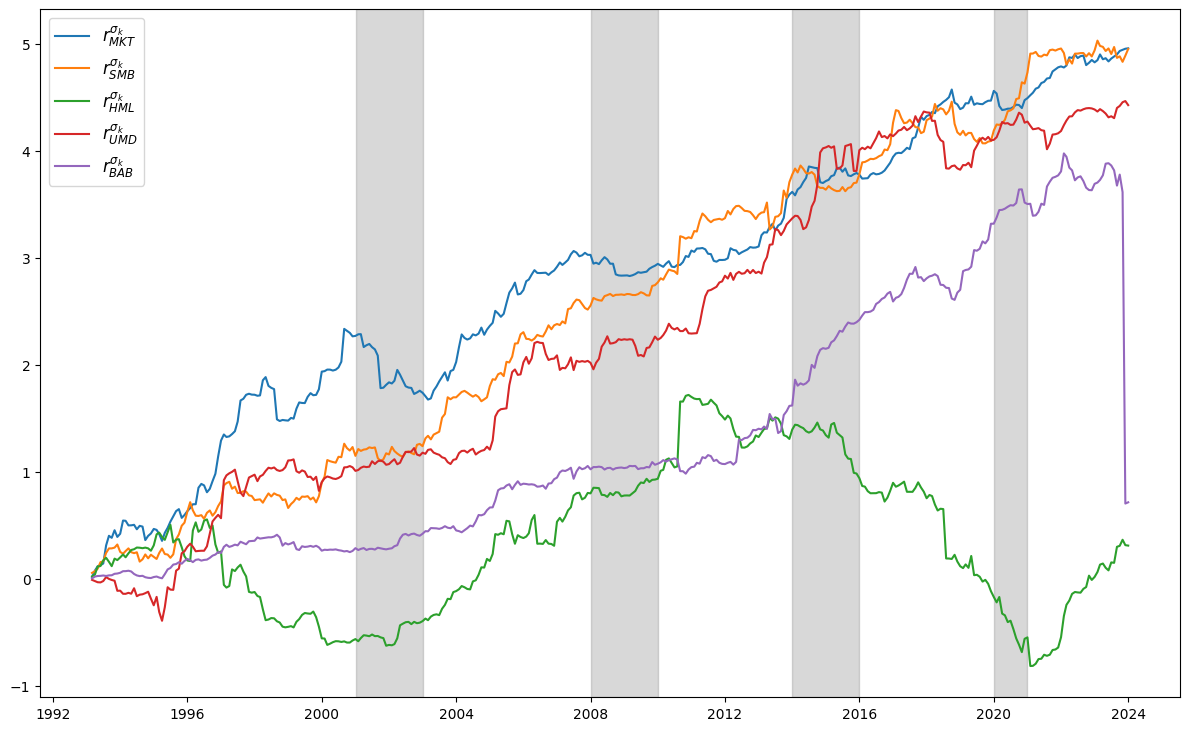

In [33]:
fig, axes = plt.subplots(1, 1, figsize=(12, 12/1.618))

ret = np.log(1 + r_sigma_k)

# Plotting cumulative returns for the entire period
for factor in ret.columns:
    axes.plot((ret[factor].cumsum()), label=rf'$r^{{\sigma_{{k}}}}_{{{factor}}}$')

# Define the recession periods
recessions = [
    ('2001-01-01', '2003-01-01'),  # Dot-com bubble and global slowdown
    ('2008-01-01', '2010-01-01'),  # Global financial crisis
    ('2014-01-01', '2016-01-01'),  # Oil price collapse
    ('2020-01-01', '2020-12-31'),  # COVID-19 pandemic
]

# Plot recession periods in grey
for start, end in recessions:
    axes.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='grey', alpha=0.3)

axes.legend(fontsize='large')
plt.tight_layout()
plt.savefig('Plots/appendix-cum_ret_r_sigma_k.png', dpi=300, bbox_inches='tight')
plt.show()

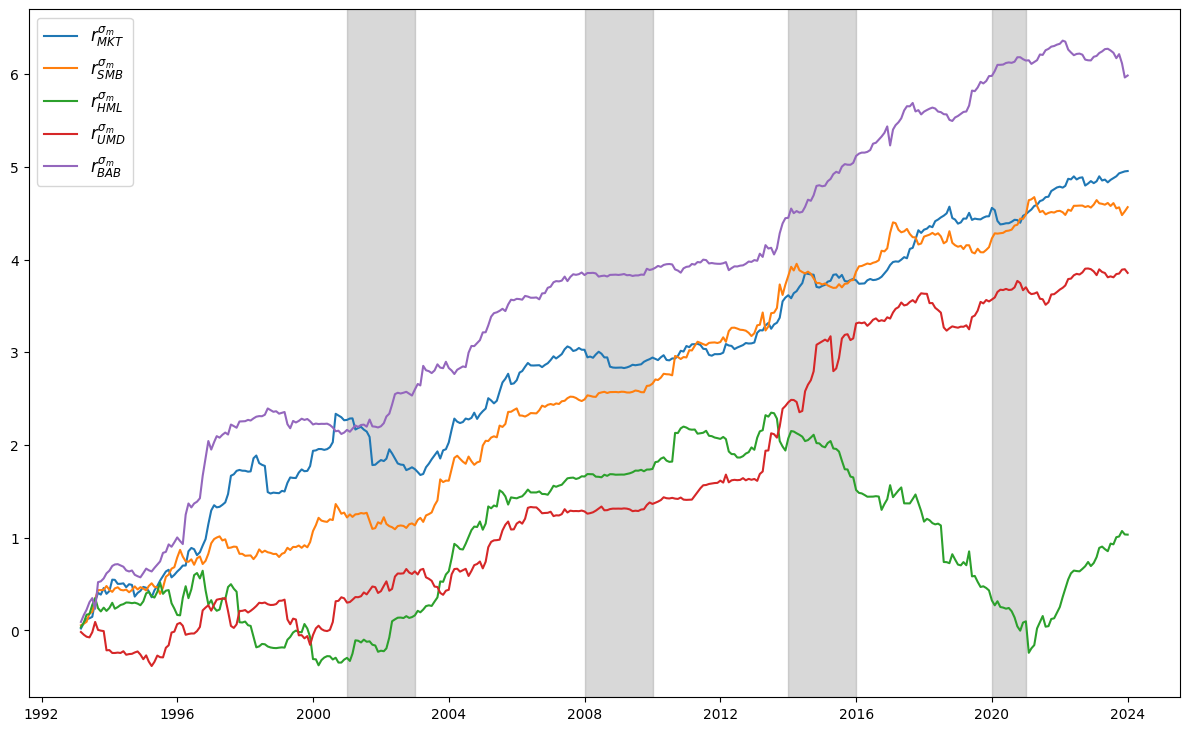

In [34]:
fig, axes = plt.subplots(1, 1, figsize=(12, 12/1.618))

ret = np.log(1 + r_sigma_m)

# Plotting cumulative returns for the entire period
for factor in ret.columns:
    axes.plot((ret[factor].cumsum()), label=rf'$r^{{\sigma_{{m}}}}_{{{factor}}}$')

# Define the recession periods
recessions = [
    ('2001-01-01', '2003-01-01'),  # Dot-com bubble and global slowdown
    ('2008-01-01', '2010-01-01'),  # Global financial crisis
    ('2014-01-01', '2016-01-01'),  # Oil price collapse
    ('2020-01-01', '2020-12-31'),  # COVID-19 pandemic
]

# Plot recession periods in grey
for start, end in recessions:
    axes.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='grey', alpha=0.3)

axes.legend(fontsize='large')
plt.tight_layout()
plt.savefig('Plots/appendix-cum_ret_r_sigma_m.png', dpi=300, bbox_inches='tight')
plt.show()

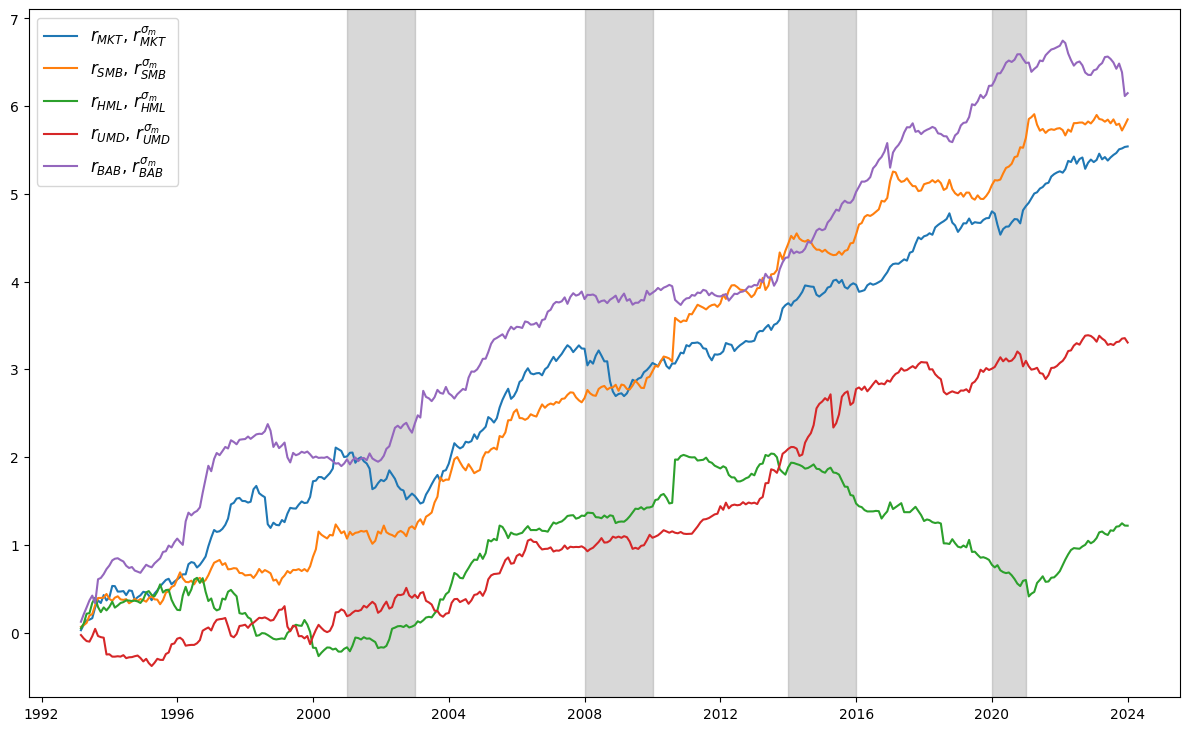

In [35]:
fig, axes = plt.subplots(1, 1, figsize=(12, 12/1.618))

ret = np.log(1 + r_sigma_m_ptf)

# Plotting cumulative returns for the entire period
for factor in ret.columns:
    axes.plot((ret[factor].cumsum()), label=rf'$r_{{{factor}}}$, $r^{{\sigma_{{m}}}}_{{{factor}}}$')

# Define the recession periods
recessions = [
    ('2001-01-01', '2003-01-01'),  # Dot-com bubble and global slowdown
    ('2008-01-01', '2010-01-01'),  # Global financial crisis
    ('2014-01-01', '2016-01-01'),  # Oil price collapse
    ('2020-01-01', '2020-12-31'),  # COVID-19 pandemic
]

# Plot recession periods in grey
for start, end in recessions:
    axes.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='grey', alpha=0.3)

axes.legend(fontsize='large')
plt.tight_layout()
plt.savefig('Plots/appendix-cum_ret_r_sigma_m_ptf.png', dpi=300, bbox_inches='tight')
plt.show()

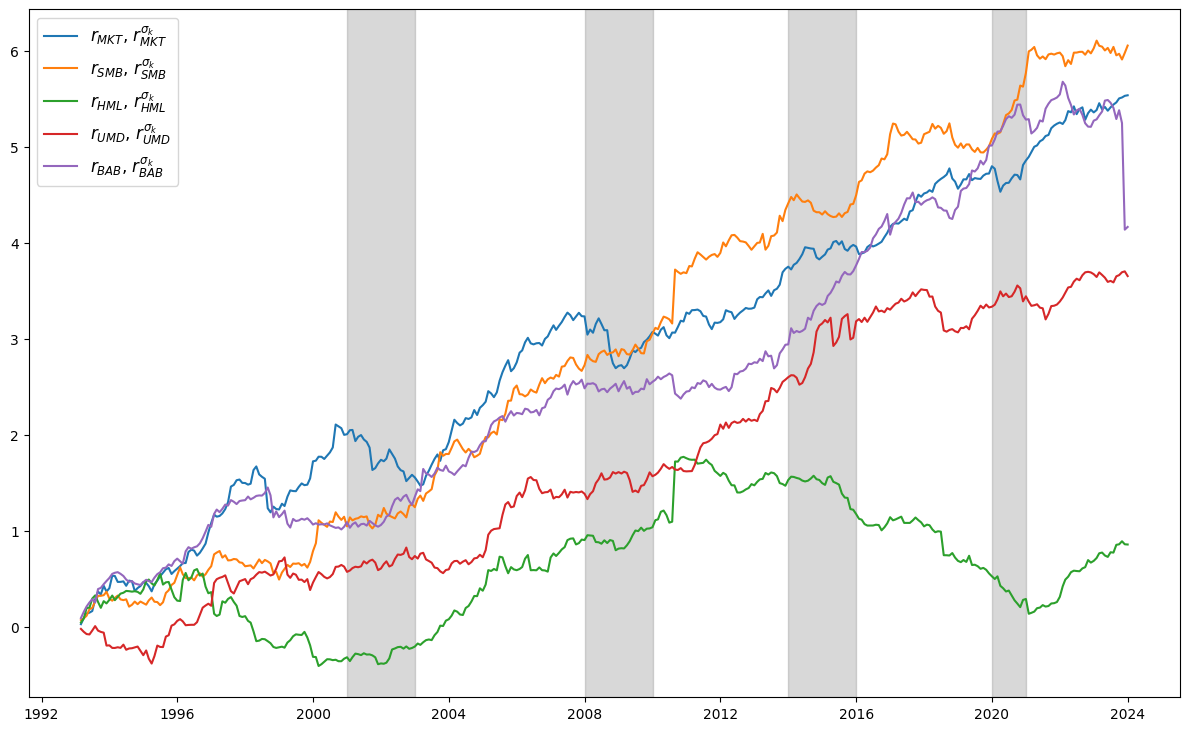

In [36]:
fig, axes = plt.subplots(1, 1, figsize=(12, 12/1.618))

ret = np.log(1 + r_sigma_k_ptf)

# Plotting cumulative returns for the entire period
for factor in ret.columns:
    axes.plot((ret[factor].cumsum()), label=rf'$r_{{{factor}}}$, $r^{{\sigma_{{k}}}}_{{{factor}}}$')

# Define the recession periods
recessions = [
    ('2001-01-01', '2003-01-01'),  # Dot-com bubble and global slowdown
    ('2008-01-01', '2010-01-01'),  # Global financial crisis
    ('2014-01-01', '2016-01-01'),  # Oil price collapse
    ('2020-01-01', '2020-12-31'),  # COVID-19 pandemic
]

# Plot recession periods in grey
for start, end in recessions:
    axes.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='grey', alpha=0.3)

axes.legend(fontsize='large')
plt.tight_layout()
plt.savefig('Plots/appendix-cum_ret_r_sigma_k_ptf.png', dpi=300, bbox_inches='tight')
plt.show()

# Using GARCH for volatility

In [37]:
### Importing arch_model
from arch import arch_model

### Extracting the data from the database
conn = sqlite3.connect('Data/data.db')

factor_ret_m = pd.read_sql('SELECT * FROM factors_monthly', conn).set_index('Date').drop(columns='rf')
factor_ret_d = pd.read_sql('SELECT * FROM factors_daily', conn).set_index('Date').drop(columns='rf')
volatility = pd.read_sql('SELECT * FROM volatility', conn).set_index('Date')

conn.close()

### Making sure all the data is in the same format
factor_ret_m.index = pd.to_datetime(factor_ret_m.index)
volatility.index = pd.to_datetime(volatility.index)

### Fixing the index of the factor_ret_m
factor_ret_m = factor_ret_m.loc[volatility.index]

### Fixing the length of the factor_ret_d
factor_ret_d = factor_ret_d.loc['1983':]

### Checking for nan
print(factor_ret_m.isna().sum().sum(), volatility.isna().sum().sum())

0 0


In [38]:
### Place to store the GARCH volatility
GARCH_vol = pd.DataFrame(index=volatility.index, columns=volatility.columns)

### Defining the window and horizen to forecast
window, horizon = 24, 21

### Looping over the columns
for factor in factor_ret_m.columns:
    ## Getting the returns
    returns = factor_ret_d[factor].dropna()
    
    ## Looping over time
    for i in range(120, len(factor_ret_m)):
        last = factor_ret_m.index[i].strftime('%Y-%m')
        first = factor_ret_m.index[i - window].strftime('%Y-%m')
        window_data = returns.loc[first:last]

        ## Fitting the GARCH model
        model = arch_model(window_data, vol='Garch', p=4, q=4, dist='t')
        model_fit = model.fit(disp='off', show_warning=False)
        forecast = model_fit.forecast(horizon=horizon)
        GARCH_vol[factor][i] = np.sqrt(forecast.variance.values.mean()) * np.sqrt(252)

### Filling in the GARCH volatility
# This makes no effect on our analysis as we only use the return from after 1993
GARCH_vol.loc[:'1993'] = volatility.loc[:'1993']

In [39]:
### Calculating the optimal c for each factor
c = pd.DataFrame(columns=factor_ret_m.columns)
c.loc['c_fac', :] = np.nan
c.loc['c_mkt', :] = np.nan

for factor in factor_ret_m.columns:
    def obj_func(c):
        vol_timed = (c / GARCH_vol[factor]) * factor_ret_m[factor]
        return (vol_timed.std() - factor_ret_m[factor].std())**2

    res = minimize(obj_func, 0.1)
    c.loc['c_fac', factor] = res.x[0]

    def obj_func(c):
        vol_timed = (c / GARCH_vol['MKT']) * factor_ret_m[factor]
        return (vol_timed.std() - factor_ret_m[factor].std())**2

    res = minimize(obj_func, 0.1)
    c.loc['c_mkt', factor] = res.x[0]

### Looking at c
print(c)

### Getting the volatility timed returns
r_sigma_k, r_sigma_m = pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns), pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns)
r_sigma_k_is, r_sigma_m_is = r_sigma_k.copy(), r_sigma_m.copy()

for factor in factor_ret_m.columns:
    r_sigma_k[factor] = (c.loc['c_fac', factor] / volatility[factor]).shift(1) * factor_ret_m[factor]
    r_sigma_m[factor] = (c.loc['c_mkt', factor] / volatility['MKT']).shift(1) * factor_ret_m[factor]
    r_sigma_k_is[factor] = (c.loc['c_fac', factor] / volatility[factor]) * factor_ret_m[factor]
    r_sigma_m_is[factor] = (c.loc['c_mkt', factor] / volatility['MKT']) * factor_ret_m[factor]

### Dropping the first row in all of our returns
r_sigma_k = r_sigma_k.iloc[1:,]
r_sigma_m = r_sigma_m.iloc[1:,]
r_sigma_k_is = r_sigma_k_is.iloc[1:,]
r_sigma_m_is = r_sigma_m_is.iloc[1:,]
r = factor_ret_m.iloc[1:,]

         MKT    SMB    HML    UMD    BAB
c_fac 0.2233 0.1923 0.1872 0.2374 0.1555
c_mkt 0.2233 0.2267 0.2673 0.2046 0.2000


In [40]:
### Defining the starting window size
window = 120

### Creating a place to store the returns
MV = pd.DataFrame(columns=[['UMV', 'CMV_k', 'CMV_m', 'UMV^s', 'CMV_k^s', 'CMV_m^s']], index=r.index).iloc[window:,]

### Getting the data we need for the expanding window
data_o = r
data_m = pd.concat([r, r_sigma_m], axis=1)
data_k = pd.concat([r, r_sigma_k], axis=1)

data_m_is = pd.concat([r, r_sigma_m_is], axis=1)
data_k_is = pd.concat([r, r_sigma_k_is], axis=1)

### Running the loop
for i in range(window, len(r)):
    ## Getting the weights
    w_o = ptf_weights(data_o.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
    w_m = ptf_weights(data_m_is.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
    w_k = ptf_weights(data_k_is.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
    w_o_s = ptf_weights(data_o.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None', shrinkage=True)
    w_m_s = ptf_weights(data_m_is.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None', shrinkage=True)
    w_k_s = ptf_weights(data_k_is.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None', shrinkage=True)

    ## Getting the returns
    MV.loc[r.index[i], 'UMV'] = (w_o * data_o.iloc[i,]).sum()
    MV.loc[r.index[i], 'CMV_m'] = (w_m * data_m.iloc[i,]).sum()
    MV.loc[r.index[i], 'CMV_k'] = (w_k * data_k.iloc[i,]).sum()
    MV.loc[r.index[i], 'UMV^s'] = (w_o_s * data_o.iloc[i,]).sum()
    MV.loc[r.index[i], 'CMV_m^s'] = (w_m_s * data_m.iloc[i,]).sum()
    MV.loc[r.index[i], 'CMV_k^s'] = (w_k_s * data_k.iloc[i,]).sum()

In [41]:
### Getting the p-values
p_values = pd.DataFrame(columns=MV.columns, index=['P-value'])

### Number of simulations
n_boot = 100000

### Getting the data we need

### Loop for in-sample or out-of-sample
for s in [0,1]:

    ### Loop for factor or market
    for f in [1,2]:

        ## Creating a list to store the differences
        diff = []

        ## Loop for the bootstrap
        for i in range(n_boot):
            # Getting the bootstrapped returns
            boot = stationary_bootstrap(np.array(MV.iloc[:, [(0+s*3), (f+s*3)]].astype(float)), 5, len(MV))

            # Adding the difference to the list
            diff.append(sharpes_ratio(boot[:,0]) - sharpes_ratio(boot[:,1]))

        ## Getting the p-value
        p_values.iloc[:,f+s*3] = (np.sum(np.array(diff) > 0) / (len(diff)))

### Looking at the p-values
p_values

,UMV,CMV_k,CMV_m,UMV^s,CMV_k^s,CMV_m^s
P-value,NaN,0.5910,0.1311,NaN,0.2749,0.0201


In [42]:
### Getting the alphas
X = MV['UMV'].astype(float)
X = sm.add_constant(X)
y = MV['CMV_k'].astype(float)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
alpha_k = model.params['const']
tstat_alpha_k = model.tvalues['const']
print(f'Annualized alpha using factor volatility: {alpha_k*12:.3f}, t-stat: {tstat_alpha_k:.3f}')

y = MV['CMV_m'].astype(float)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
alpha_m = model.params['const']
tstat_alpha_m = model.tvalues['const']
print(f'Annualized alpha using market volatility: {alpha_m*12:.3f}, t-stat: {tstat_alpha_m:.3f}')

X = MV['UMV^s'].astype(float)
X = sm.add_constant(X)
y = MV['CMV_k^s'].astype(float)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
alpha_k_s = model.params['const']
tstat_alpha_k_s = model.tvalues['const']
print(f'Annualized alpha using factor volatility and shirnkage: {alpha_k_s*12:.3f}, t-stat: {tstat_alpha_k_s:.3f}')

y = MV['CMV_m^s'].astype(float)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
alpha_m_s = model.params['const']
tstat_alpha_m_s = model.tvalues['const']
print(f'Annualized alpha using market volatility and shirnkage: {alpha_m_s*12:.3f}, t-stat: {tstat_alpha_m_s:.3f}')

Annualized alpha using factor volatility: 0.044, t-stat: 1.077
Annualized alpha using market volatility: 0.101, t-stat: 2.683
Annualized alpha using factor volatility and shirnkage: 0.069, t-stat: 2.030
Annualized alpha using market volatility and shirnkage: 0.114, t-stat: 3.886


In [43]:
### Creating  a latex table
latex = pd.DataFrame(columns=MV.columns, index=['Mean', 'Standard deviation', 'Sharpe ratio', r'p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)', r'$\alpha$ (\%)', r'$t$($\alpha$)'])

latex.loc['Mean', :] = MV.mean().values * 12
latex.loc['Standard deviation', :] = MV.std().values * np.sqrt(12)
latex.loc['Sharpe ratio', :] = sharpes_ratio(MV).values
latex.loc[r'p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$)', :] = p_values.loc['P-value'].values
latex.loc[r'$\alpha$ (\%)', 'CMV_k'] = alpha_k * 12 * 100
latex.loc[r'$\alpha$ (\%)', 'CMV_m'] = alpha_m * 12 * 100
latex.loc[r'$\alpha$ (\%)', 'CMV_k^s'] = alpha_k_s * 12 * 100
latex.loc[r'$\alpha$ (\%)', 'CMV_m^s'] = alpha_m_s * 12 * 100
latex.loc[r'$t$($\alpha$)', 'CMV_k'] = tstat_alpha_k
latex.loc[r'$t$($\alpha$)', 'CMV_m'] = tstat_alpha_m
latex.loc[r'$t$($\alpha$)', 'CMV_k^s'] = tstat_alpha_k_s
latex.loc[r'$t$($\alpha$)', 'CMV_m^s'] = tstat_alpha_m_s

### Saving the table
latex.to_latex('Tables/appendix-managed_portfolios_with_GARCH.tex', na_rep='', index=True, float_format='%.3f', escape=False, multirow=True, multicolumn=True)
latex

,UMV,CMV_k,CMV_m,UMV^s,CMV_k^s,CMV_m^s
Mean,0.4994,0.6951,0.5981,0.4467,0.7046,0.6264
Standard deviation,0.3048,0.4299,0.3309,0.2751,0.4210,0.3426
Sharpe ratio,1.6386,1.6167,1.8074,1.6235,1.6737,1.8284
p-value(SR$_{\text{CMV}}$ - SR$_{\text{UMV}}$),NaN,0.5910,0.1311,NaN,0.2749,0.0201
$\alpha$ (\%),NaN,4.3626,10.1118,NaN,6.9472,11.3755
$t$($\alpha$),NaN,1.0768,2.6832,NaN,2.0304,3.8862
